In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, train_test_split
from tkinter import Tk, filedialog, simpledialog, messagebox
from matplotlib.backends.backend_pdf import PdfPages

# Función para seleccionar archivo CSV
def select_file():
    root = Tk()
    root.withdraw()  # Ocultar la ventana principal
    file_path = filedialog.askopenfilename(title="Selecciona el archivo CSV", filetypes=[("CSV files", "*.csv")])
    return file_path

# Función para seleccionar el header (columna)
def select_column(df, prompt):
    columns = df.columns.tolist()
    column = simpledialog.askstring("Input", f"{prompt}\nOpciones disponibles:\n" + "\n".join(columns))
    if column not in columns:
        print(f"Columna {column} no encontrada. Se usará la primera columna disponible: {columns[0]}")
        return columns[0]
    return column

# Función para seleccionar la cantidad de variables a tratar
def select_number_of_variables():
    root = Tk()
    root.withdraw()
    num_vars = simpledialog.askinteger("Input", "¿Cuántas variables deseas utilizar? (mínimo 2)")
    if num_vars is None or num_vars < 2:
        messagebox.showwarning("Advertencia", "Número inválido. Se utilizarán 2 variables por defecto.")
        return 2
    return num_vars

# Seleccionar cantidad de variables
num_vars = select_number_of_variables()

# Seleccionar archivos CSV
dataframes = []
column_names = []

for i in range(num_vars):
    file = select_file()
    df = pd.read_csv(file, parse_dates=['fecha'], index_col='fecha')
    column = select_column(df, f"Escribe el nombre de la columna de la variable {i+1}:")
    dataframes.append(df)
    column_names.append(column)

# Resamplear cada dataframe para obtener la media diaria
for i in range(num_vars):
    dataframes[i] = dataframes[i].resample('D').mean()

# Crear un DataFrame combinado con las variables seleccionadas
data_combined = pd.DataFrame(index=dataframes[0].index)

for i in range(num_vars):
    data_combined[column_names[i]] = dataframes[i][column_names[i]]

# Escalar los datos entre 0 y 1
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data_combined)

# Transformar los datos para usar en SVM
look_back = 90
forecast_horizon = 7

# Crear características y etiquetas
def create_features_labels(data, look_back, forecast_horizon):
    X, y = [], []
    for i in range(len(data) - look_back - forecast_horizon):
        X.append(data[i:(i + look_back), :])  # Características de entrada
        y.append(data[(i + look_back):(i + look_back + forecast_horizon), 0])  # Predecir la primera variable
    return np.array(X), np.array(y)

# Crear las características y etiquetas para el modelo
X, y = create_features_labels(data_scaled, look_back, forecast_horizon)

# Aplanar los datos para SVM (cada fila representa un conjunto de características)
X_flat = X.reshape(X.shape[0], -1)
y_flat = y[:, 0]  # Utilizamos solo la primera etiqueta (día 1) para simplificar

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_flat, y_flat, test_size=0.2, random_state=42)

# Definir el rango de hiperparámetros para GridSearchCV
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto'],
    'kernel': ['rbf', 'linear']
}

# Crear el modelo SVM
svr = SVR()

# Usar GridSearchCV para encontrar los mejores hiperparámetros
grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)
grid_search.fit(X_train, y_train)

# Mejor modelo
best_svr = grid_search.best_estimator_
print(f"Mejores parámetros: {grid_search.best_params_}")

# Realizar predicciones con el mejor modelo
y_pred_train = best_svr.predict(X_train)
y_pred_test = best_svr.predict(X_test)

# Generar nombre del archivo PDF dinámico basado en variables y nombres de las columnas
pdf_filename = f'pronostico_SVM_{num_vars}_variables_{"_".join(column_names)}.pdf'

# Crear el archivo PDF para guardar gráficos y métricas
with PdfPages(pdf_filename) as pdf:
    # Página 1: Información general
    plt.figure(figsize=(8, 6))
    plt.text(0.5, 0.8, f'Variables Utilizadas en el Pronóstico:', ha='center', fontsize=14)
    plt.text(0.5, 0.7, f"{', '.join(column_names)}", ha='center', fontsize=12)
    plt.text(0.5, 0.6, f'Variable Pronosticada: {column_names[0]}', ha='center', fontsize=14)
    plt.text(0.5, 0.5, f'Mejores Parámetros: {grid_search.best_params_}', ha='center', fontsize=12)
    plt.axis('off')
    pdf.savefig()
    plt.close()

    # Pronóstico para cada día a futuro
    for day in range(forecast_horizon):
        y_pred_test_day = y[:, day]
        y_pred_test_day_unscaled = scaler.inverse_transform(
            np.concatenate([y_pred_test_day.reshape(-1, 1), np.zeros((len(y_pred_test_day), num_vars - 1))], axis=1)
        )[:, 0]
        y_test_day_unscaled = scaler.inverse_transform(
            np.concatenate([y[:, day].reshape(-1, 1), np.zeros((len(y[:, day]), num_vars - 1))], axis=1)
        )[:, 0]

        # Calcular métricas para el día específico
        rmse_day = np.sqrt(mean_squared_error(y_test_day_unscaled, y_pred_test_day_unscaled))
        mae_day = mean_absolute_error(y_test_day_unscaled, y_pred_test_day_unscaled)
        r2_day = r2_score(y_test_day_unscaled, y_pred_test_day_unscaled)

        # Gráfico de predicción vs realidad para el día
        plt.figure(figsize=(10, 5))
        plt.plot(range(len(y_test_day_unscaled)), y_test_day_unscaled, label='Valor Real')
        plt.plot(range(len(y_pred_test_day_unscaled)), y_pred_test_day_unscaled, label='Pronóstico SVM', color='red')
        plt.title(f'Pronóstico vs Valor Real - Día {day + 1}')
        plt.xlabel('Muestras')
        plt.ylabel(f'{column_names[0]} (Día {day + 1})')
        plt.legend()
        plt.grid(True)
        plt.text(0.5, 0.1, f'RMSE: {rmse_day:.4f}, MAE: {mae_day:.4f}, R²: {r2_day:.4f}', ha='center', fontsize=12, transform=plt.gcf().transFigure)
        pdf.savefig()
        plt.close()

# Mensaje de finalización
print(f"Resultados y gráficos guardados en el archivo {pdf_filename}.")


/var/folders/ld/lp18grh57gj_zwvnvgvp7cl40000gp/T/ipykernel_79019/2407705762.py:46: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(file, parse_dates=['fecha'], index_col='fecha')
/var/folders/ld/lp18grh57gj_zwvnvgvp7cl40000gp/T/ipykernel_79019/2407705762.py:46: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(file, parse_dates=['fecha'], index_col='fecha')


Fitting 5 folds for each of 16 candidates, totalling 80 fits
Mejores parámetros: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Resultados y gráficos guardados en el archivo pronostico_SVM_2_variables_H12. Pita Bocatoma_5025. Pita DJ Hualpaloma.pdf.


In [3]:
# Importar las bibliotecas necesarias
import pandas as pd
import xarray as xr

# Paso 1: Cargar el archivo CSV
# Reemplaza 'archivo.csv' con la ruta de tu archivo CSV
csv_file = '/Users/manuelnarvaez/Documents/DuniaConsultoria/Estaciones/estaciones.csv'
df = pd.read_csv(csv_file)

# Mostrar las primeras filas para asegurarse de que se cargó correctamente
df.head()

# Paso 2: Cargar el archivo NetCDF
# Reemplaza 'archivo.nc' con la ruta de tu archivo NetCDF
nc_file = '/Users/manuelnarvaez/Documents/DuniaConsultoria/Estaciones/clima_final_final.nc'
data = xr.open_dataset(nc_file)

# Mostrar las variables disponibles en el NetCDF
data

# Paso 3: Definir una función para extraer la serie temporal
def extraer_serie(codigo, lat, lon, data):
    # Utilizar el método 'sel' de xarray para seleccionar el punto más cercano
    serie = data.Precipitacion.sel(lat=lat, lon=lon, method='nearest')
    return serie

# Paso 4: Crear un diccionario para almacenar las series (opcional)
series_dict = {}

# Paso 5: Iterar a través de cada fila del dataframe para extraer y guardar la serie
for index, row in df.iterrows():
    codigo = row['codigo']
    lat = row['lat']
    lon = row['lon']
    
    # Extraer la serie temporal
    serie = extraer_serie(codigo, lat, lon, data)
    
    # Convertir la serie a un DataFrame
    serie_df = serie.to_dataframe().reset_index()
    
    # Guardar el DataFrame en un archivo CSV con el nombre del código
    output_filename = f'serie_{codigo}.csv'
    serie_df.to_csv(output_filename, index=False)
    
    # Almacenar en el diccionario (opcional)
    series_dict[codigo] = serie_df

    print(f'Serie temporal para código {codigo} guardada en {output_filename}')

# Paso 6: Verificar un archivo guardado
# Puedes abrir uno de los archivos generados para revisar su contenido
serie_df.head()


Serie temporal para código M5021 guardada en serie_M5021.csv
Serie temporal para código M5022 guardada en serie_M5022.csv
Serie temporal para código M5023 guardada en serie_M5023.csv
Serie temporal para código M5024 guardada en serie_M5024.csv
Serie temporal para código M5025 guardada en serie_M5025.csv
Serie temporal para código M5074 guardada en serie_M5074.csv
Serie temporal para código M5075 guardada en serie_M5075.csv
Serie temporal para código M5179 guardada en serie_M5179.csv
Serie temporal para código C12 guardada en serie_C12.csv
Serie temporal para código P57 guardada en serie_P57.csv
Serie temporal para código C13 guardada en serie_C13.csv
Serie temporal para código P37 guardada en serie_P37.csv
Serie temporal para código C16 guardada en serie_C16.csv
Serie temporal para código P34 guardada en serie_P34.csv
Serie temporal para código P40 guardada en serie_P40.csv
Serie temporal para código P46 guardada en serie_P46.csv
Serie temporal para código P62 guardada en serie_P62.csv

time        lon       lat  spatial_ref  Precipitacion
0 2008-01-01 -78.412835 -0.428507            0       0.482711
1 2008-01-02 -78.412835 -0.428507            0       0.482711
2 2008-01-03 -78.412835 -0.428507            0       0.577220
3 2008-01-04 -78.412835 -0.428507            0       1.016566
4 2008-01-05 -78.412835 -0.428507            0       5.976614

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tkinter import Tk, filedialog, simpledialog, messagebox
from matplotlib.backends.backend_pdf import PdfPages
from scipy import stats

# Calcular los intervalos de confianza
def calculate_confidence_intervals(predictions, true_values, confidence=0.95):
    n = len(predictions)
    mean_error = np.mean(predictions - true_values)
    se = stats.sem(predictions - true_values)  # Error estándar
    h = se * stats.t.ppf((1 + confidence) / 2, n - 1)  # Intervalo de confianza
    
    lower_bound = predictions - h
    upper_bound = predictions + h
    
    return lower_bound, upper_bound


# Función para seleccionar archivo CSV
def select_file():
    root = Tk()
    root.withdraw()  # Ocultar la ventana principal
    file_path = filedialog.askopenfilename(title="Selecciona el archivo CSV", filetypes=[("CSV files", "*.csv")])
    return file_path

# Función para seleccionar el header (columna)
def select_column(df, prompt):
    columns = df.columns.tolist()
    column = simpledialog.askstring("Input", f"{prompt}\nOpciones disponibles:\n" + "\n".join(columns))
    if column not in columns:
        print(f"Columna {column} no encontrada. Se usará la primera columna disponible: {columns[0]}")
        return columns[0]
    return column

# Función para seleccionar la cantidad de variables a tratar
def select_number_of_variables():
    root = Tk()
    root.withdraw()
    num_vars = simpledialog.askinteger("Input", "¿Cuántas variables deseas utilizar? (mínimo 2)")
    if num_vars is None or num_vars < 2:
        messagebox.showwarning("Advertencia", "Número inválido. Se utilizarán 2 variables por defecto.")
        return 2
    return num_vars

# Seleccionar cantidad de variables
num_vars = select_number_of_variables()

# Seleccionar archivos CSV
dataframes = []
column_names = []

for i in range(num_vars):
    file = select_file()
    df = pd.read_csv(file, parse_dates=['fecha'], index_col='fecha')
    df.index = pd.to_datetime(df.index)
    column = select_column(df, f"Escribe el nombre de la columna de la variable {i+1}:")
    dataframes.append(df)
    column_names.append(column)

# Resamplear cada dataframe para obtener la media diaria
for i in range(num_vars):
    dataframes[i] = dataframes[i].resample('D').mean()

# Crear un DataFrame combinado con las variables seleccionadas
data_combined = pd.DataFrame(index=dataframes[0].index)

for i in range(num_vars):
    data_combined[column_names[i]] = dataframes[i][column_names[i]]

# Escalar los datos entre 0 y 1
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data_combined)

# Dividir los datos en conjunto de entrenamiento y prueba (80% - 20%)
train_size = int(len(data_scaled) * 0.8)
train, test = data_scaled[:train_size], data_scaled[train_size:]

# Crear una función para transformar los datos en formato adecuado para LSTM (multivariables)
def create_dataset(data, look_back=70, forecast_horizon=7):
    X, y = [], []
    for i in range(len(data) - look_back - forecast_horizon):
        X.append(data[i:(i + look_back), :])  # Tomar todas las características
        y.append(data[(i + look_back):(i + look_back + forecast_horizon), 0])  # Predecir la primera variable
    return np.array(X), np.array(y)

# Usamos 90 días para predecir los próximos 7 días
look_back = 70
forecast_horizon = 7
X_train, y_train = create_dataset(train, look_back, forecast_horizon)
X_test, y_test = create_dataset(test, look_back, forecast_horizon)

# Reshape para que el modelo LSTM lo entienda (samples, time steps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

# Parámetros de entrenamiento
epochs = 40
batch_size = 5

# Crear el modelo LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(look_back, num_vars)))  # Hay 'num_vars' variables de entrada
model.add(LSTM(50))
model.add(Dense(forecast_horizon))  # Predecir los próximos 7 días

# Compilar el modelo
model.compile(loss='mean_absolute_error', optimizer='adam')

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=2)

# Realizar el pronóstico para el conjunto de entrenamiento
train_predict = model.predict(X_train)

# Realizar el pronóstico para el conjunto de prueba
test_predict = model.predict(X_test)

# Invertir el escalado para las predicciones y los valores reales del entrenamiento
train_predict_unscaled = []
y_train_unscaled = []

for i in range(train_predict.shape[0]):
    temp_train_predict = scaler.inverse_transform(np.concatenate([train_predict[i].reshape(-1, 1), np.tile(X_train[i, -1, 1:], (forecast_horizon, 1))], axis=1))[:, 0]
    temp_y_train = scaler.inverse_transform(np.concatenate([y_train[i].reshape(-1, 1), np.tile(X_train[i, -1, 1:], (forecast_horizon, 1))], axis=1))[:, 0]
    train_predict_unscaled.append(temp_train_predict)
    y_train_unscaled.append(temp_y_train)

train_predict_unscaled = np.array(train_predict_unscaled)
y_train_unscaled = np.array(y_train_unscaled)

# Invertir el escalado para las predicciones y los valores reales del conjunto de prueba
test_predict_unscaled = []
y_test_unscaled = []

for i in range(test_predict.shape[0]):
    temp_predict = scaler.inverse_transform(np.concatenate([test_predict[i].reshape(-1, 1), np.tile(X_test[i, -1, 1:], (forecast_horizon, 1))], axis=1))[:, 0]
    temp_y_test = scaler.inverse_transform(np.concatenate([y_test[i].reshape(-1, 1), np.tile(X_test[i, -1, 1:], (forecast_horizon, 1))], axis=1))[:, 0]
    test_predict_unscaled.append(temp_predict)
    y_test_unscaled.append(temp_y_test)

test_predict_unscaled = np.array(test_predict_unscaled)
y_test_unscaled = np.array(y_test_unscaled)



# Calcular los intervalos de confianza para las predicciones de prueba
confidence_intervals_test = {'lower': [], 'upper': []}

for day in range(forecast_horizon):
    lower_bound, upper_bound = calculate_confidence_intervals(test_predict_unscaled[:, day], y_test_unscaled[:, day])
    confidence_intervals_test['lower'].append(lower_bound)
    confidence_intervals_test['upper'].append(upper_bound)


# Guardar las predicciones y los valores reales en archivos CSV separados por cada día de pronóstico
for day in range(forecast_horizon):
    df_results = pd.DataFrame({
        'Fecha': data_combined.index[-len(y_test_unscaled):],
        'Valor Real': y_test_unscaled[:, day],
        'Pronóstico': test_predict_unscaled[:, day]
    })
    df_results.to_csv(f'predicciones_dia_{day + 1}.csv', index=False)
    print(f'Datos guardados en "predicciones_dia_{day + 1}.csv"')

# Calcular las métricas RMSE, MAE y R² para cada día de pronóstico en el conjunto de prueba (1er a 7mo día)
metrics_test = {'RMSE': [], 'MAE': [], 'R²': []}

for day in range(forecast_horizon):
    rmse = np.sqrt(mean_squared_error(y_test_unscaled[:, day], test_predict_unscaled[:, day]))
    mae = mean_absolute_error(y_test_unscaled[:, day], test_predict_unscaled[:, day])
    r2 = r2_score(y_test_unscaled[:, day], test_predict_unscaled[:, day])
    
    metrics_test['RMSE'].append(rmse)
    metrics_test['MAE'].append(mae)
    metrics_test['R²'].append(r2)
    print(f"Día {day + 1} - Test RMSE: {rmse}, Test MAE: {mae}, Test R²: {r2}")

# Calcular las métricas RMSE, MAE y R² para cada día de pronóstico en el conjunto de entrenamiento
metrics_train = {'RMSE': [], 'MAE': [], 'R²': []}

for day in range(forecast_horizon):
    rmse = np.sqrt(mean_squared_error(y_train_unscaled[:, day], train_predict_unscaled[:, day]))
    mae = mean_absolute_error(y_train_unscaled[:, day], train_predict_unscaled[:, day])
    r2 = r2_score(y_train_unscaled[:, day], train_predict_unscaled[:, day])
    
    metrics_train['RMSE'].append(rmse)
    metrics_train['MAE'].append(mae)
    metrics_train['R²'].append(r2)
    print(f"Día {day + 1} - Train RMSE: {rmse}, Train MAE: {mae}, Train R²: {r2}")

# Generar nombre del archivo PDF dinámico basado en variables y nombres de las columnas
pdf_filename = f'pronostico_70_10_60_netcdf_{num_vars}_variables_{"_".join(column_names)}.pdf'

# Crear el archivo PDF para guardar gráficos y métricas
with PdfPages(pdf_filename) as pdf:
    # Página 1: Información general
    plt.figure(figsize=(8, 6))
    plt.text(0.5, 0.8, f'Variables Utilizadas en el Pronóstico:', ha='center', fontsize=14)
    plt.text(0.5, 0.7, f"{', '.join(column_names)}", ha='center', fontsize=12)
    plt.text(0.5, 0.6, f'Variable Pronosticada: {column_names[0]}', ha='center', fontsize=14)
    plt.text(0.5, 0.5, f'Epochs: {epochs}, Batch Size: {batch_size}', ha='center', fontsize=14)
    plt.text(0.5, 0.4, 'Métricas de Ajuste (Conjunto de Prueba):', ha='center', fontsize=14)
    for i in range(forecast_horizon):
        plt.text(0.5, 0.3 - i*0.05, f"Día {i + 1} - RMSE: {metrics_test['RMSE'][i]:.4f}, MAE: {metrics_test['MAE'][i]:.4f}, R²: {metrics_test['R²'][i]:.4f}",
                 ha='center', fontsize=12)
    plt.axis('off')
    pdf.savefig()
    plt.close()

    # Gráficos de entrenamiento: Pérdida vs Epochs
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Pérdida Entrenamiento')
    plt.plot(history.history['val_loss'], label='Pérdida Validación')
    plt.title('Pérdida del Modelo Durante el Entrenamiento')
    plt.xlabel('Epochs')
    plt.ylabel('Pérdida (MAE)')
    plt.legend()
    plt.grid(True)
    pdf.savefig()
    plt.close()

    # Gráficos de predicción vs realidad para cada día, incluyendo los intervalos de confianza
    for day in range(forecast_horizon):
        plt.figure(figsize=(10, 5))
        
        # Graficar período de entrenamiento
        plt.plot(data_combined.index[:train_size][-len(y_train_unscaled):], y_train_unscaled[:, day], label=f'Valor Real Entrenamiento (Día {day+1})', color='blue')
        plt.plot(data_combined.index[:train_size][-len(y_train_unscaled):], train_predict_unscaled[:, day], label=f'Pronóstico Entrenamiento (Día {day+1})', color='cyan')
        
        # Graficar período de prueba
        plt.plot(data_combined.index[-len(y_test_unscaled):], y_test_unscaled[:, day], label=f'Valor Real Prueba (Día {day+1})', color='green')
        plt.plot(data_combined.index[-len(y_test_unscaled):], test_predict_unscaled[:, day], label=f'Pronóstico Prueba (Día {day+1})', color='red')
        
        # Graficar intervalos de confianza
        plt.fill_between(data_combined.index[-len(y_test_unscaled):], 
                         confidence_intervals_test['lower'][day], 
                         confidence_intervals_test['upper'][day], 
                         color='gray', alpha=0.2, label='Intervalo de Confianza 95%')
        
        # Mostrar métricas del entrenamiento y prueba
        plt.title(f'Pronóstico del Día {day+1} (Entrenamiento y Prueba)')
        plt.xlabel('Fecha')
        plt.ylabel(column_names[0])  # Mostrar nombre de la primera variable
        plt.legend()
        plt.grid(True)
        plt.figtext(0.15, 0.15, f"Train RMSE: {metrics_train['RMSE'][day]:.4f}, Train MAE: {metrics_train['MAE'][day]:.4f}, Train R²: {metrics_train['R²'][day]:.4f}", fontsize=10, ha='left')
        plt.figtext(0.15, 0.10, f"Test RMSE: {metrics_test['RMSE'][day]:.4f}, Test MAE: {metrics_test['MAE'][day]:.4f}, Test R²: {metrics_test['R²'][day]:.4f}", fontsize=10, ha='left')
        pdf.savefig()
        plt.close()


    # Gráfico de todas las métricas por día (conjunto de prueba)
    plt.figure(figsize=(10, 5))
    days = range(1, 8)
    plt.plot(days, metrics_test['RMSE'], label='Test RMSE', marker='o')
    plt.plot(days, metrics_test['MAE'], label='Test MAE', marker='o')
    plt.plot(days, metrics_test['R²'], label='Test R²', marker='o')
    plt.title('Métricas de Pronóstico para Cada Día (Conjunto de Prueba)')
    plt.xlabel('Día de Pronóstico')
    plt.ylabel('Métrica')
    plt.legend()
    plt.grid(True)
    pdf.savefig()
    plt.close()

# Mensaje de finalización
print(f"Resultados y gráficos guardados en el archivo {pdf_filename}.")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# Función de confianza modificada
def confianza2(test_predict_unscaled, y_test_unscaled, forecast_horizon):
    # Definir los percentiles que quieres en el eje X
    percentiles_x = [2.5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 97.5]
    percentiles_labels = ['P2.5', 'P10', 'P20', 'P30', 'P40', 'P50', 'P60', 'P70', 'P80', 'P90', 'P97.5']

    # Crear DataFrames para cada día y calcular percentiles y rangos en bucle
    dias_percentiles = {}
    
    for dia in range(1, forecast_horizon + 1):
        # Ordenar los valores del día 'dia' en las predicciones
        ordenados = pd.Series(test_predict_unscaled[:, dia - 1]).dropna().sort_values(ascending=True).reset_index(drop=True)

        # Crear un DataFrame para el día actual
        dia_df = pd.DataFrame({'Nombre': percentiles_labels})

        # Calcular los percentiles
        dia_df['percentiles'] = [np.percentile(ordenados, i) for i in percentiles_x]

        # Función para calcular los rangos C10, C90, C5, C95
        def calcular_rang(ordenados, percentil, percentiles_x):
            # Obtener el percentil anterior
            if percentil == percentiles_x[0]:
                p_anterior = 0  # Para el primer percentil, se puede usar 0 o un valor que no limite
            else:
                p_anterior = np.percentile(ordenados, percentiles_x[percentiles_x.index(percentil) - 1])

            # Filtrar los datos que son mayores que el percentil anterior
            p = ordenados[(ordenados <= np.percentile(ordenados, percentil)) & (ordenados > p_anterior)]

            # Calcular los percentiles
            c10 = np.percentile(p, 10) if len(p) > 0 else np.nan  # Verificar longitud para evitar errores
            c90 = np.percentile(p, 90) if len(p) > 0 else np.nan
            c5 = np.percentile(p, 5) if len(p) > 0 else np.nan
            c95 = np.percentile(p, 95) if len(p) > 0 else np.nan
            return c10, c90, c5, c95

        # Calcular los rangos para cada percentil y agregar al DataFrame
        dia_df[['C10', 'C90', 'C5', 'C95']] = [calcular_rang(ordenados, i, percentiles_x) for i in percentiles_x]

        # Guardar el DataFrame del día en el diccionario
        dias_percentiles[f'Dia_{dia}'] = dia_df

    # Guardar gráficos en PDF
    pdf_filename = "intervalos_confianza_percentiles_por_dia.pdf"
    with PdfPages(pdf_filename) as pdf:
        # Graficar los percentiles y rangos para cada día
        for dia in range(1, forecast_horizon + 1):
            Dia = dias_percentiles[f'Dia_{dia}']

            plt.figure(figsize=(10, 6))
            plt.plot(Dia['Nombre'], np.percentile(y_test_unscaled[:, dia - 1], percentiles_x), label='Real', color='black', linewidth=1.5)

            # Graficar el intervalo de confianza para cada día
            plt.fill_between(Dia['Nombre'], Dia['C10'], Dia['C90'], color='blue', alpha=0.2, label='C10-C90')
            plt.fill_between(Dia['Nombre'], Dia['C5'], Dia['C95'], color='gray', alpha=0.2, label='C5-C95')

            # Etiquetas y título
            plt.title(f'Día {dia} - Intervalo de Confianza')
            plt.xlabel('Percentil')
            plt.ylabel('Valor Pronosticado')
            plt.grid(True)
            plt.legend(loc='upper left')
            
            # Guardar el gráfico en el PDF
            pdf.savefig()
            plt.close()

    print(f"Gráficos guardados en el archivo PDF: {pdf_filename}")
    return dias_percentiles

# Llamar a la función para generar el PDF con los gráficos
forecast_horizon = 7  # Número de días a pronosticar
dias_percentiles = confianza2(test_predict_unscaled, y_test_unscaled, forecast_horizon)


/var/folders/ld/lp18grh57gj_zwvnvgvp7cl40000gp/T/ipykernel_93015/2137474517.py:60: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(file, parse_dates=['fecha'], index_col='fecha')
/var/folders/ld/lp18grh57gj_zwvnvgvp7cl40000gp/T/ipykernel_93015/2137474517.py:60: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(file, parse_dates=['fecha'], index_col='fecha')
/var/folders/ld/lp18grh57gj_zwvnvgvp7cl40000gp/T/ipykernel_93015/2137474517.py:60: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(file, parse_dates=['fecha'], index_col='fecha'

Epoch 1/40
224/224 - 6s - loss: 0.0059 - val_loss: 0.0040 - 6s/epoch - 25ms/step
Epoch 2/40
224/224 - 4s - loss: 0.0034 - val_loss: 0.0037 - 4s/epoch - 18ms/step
Epoch 3/40
224/224 - 4s - loss: 0.0030 - val_loss: 0.0034 - 4s/epoch - 18ms/step
Epoch 4/40
224/224 - 4s - loss: 0.0028 - val_loss: 0.0033 - 4s/epoch - 18ms/step
Epoch 5/40
224/224 - 4s - loss: 0.0026 - val_loss: 0.0033 - 4s/epoch - 18ms/step
Epoch 6/40
224/224 - 4s - loss: 0.0023 - val_loss: 0.0026 - 4s/epoch - 18ms/step
Epoch 7/40
224/224 - 4s - loss: 0.0021 - val_loss: 0.0027 - 4s/epoch - 18ms/step
Epoch 8/40
224/224 - 4s - loss: 0.0023 - val_loss: 0.0026 - 4s/epoch - 17ms/step
Epoch 9/40
224/224 - 4s - loss: 0.0020 - val_loss: 0.0023 - 4s/epoch - 18ms/step
Epoch 10/40
224/224 - 4s - loss: 0.0020 - val_loss: 0.0029 - 4s/epoch - 18ms/step
Epoch 11/40
224/224 - 4s - loss: 0.0020 - val_loss: 0.0025 - 4s/epoch - 18ms/step
Epoch 12/40
224/224 - 4s - loss: 0.0022 - val_loss: 0.0024 - 4s/epoch - 18ms/step
Epoch 13/40
224/224 - 4s 

In [ ]:
import os
import rasterio
import numpy as np
import xarray as xr
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# Ruta base de los datos
base_path = "/Users/manuelnarvaez/Downloads/WRF"  # Cambia esta ruta a la ubicación de tus carpetas

# Definir los tipos esperados y los días de pronóstico
expected_types = ['c', 'e', 'nc']
expected_days = [1, 2, 3]  # Primer, segundo y tercer día de pronóstico

# Función para obtener la fecha inicial del pronóstico desde el nombre del directorio
def get_start_date_from_path(path):
    try:
        # Extraer los componentes del path y buscar la carpeta que sigue el patrón "YYYY_MM_DD_00Z"
        path_parts = path.split(os.sep)
        for part in path_parts:
            if len(part.split('_')) == 4 and part.endswith('00Z'):
                year, month, day, _ = part.split('_')
                start_date = datetime(int(year), int(month), int(day))
                return start_date
    except Exception as e:
        print(f"No se pudo obtener la fecha inicial del pronóstico de la ruta: {path}. Error: {e}")
        return None

# Función para obtener el tipo y día de pronóstico desde el nombre del archivo
def get_forecast_info_from_filename(file_name, start_date):
    try:
        # Extraer el tipo y la fecha del archivo
        _, tipo, day_str, month_str, year_str = file_name.split('-')
        # Crear la fecha del archivo
        file_date = datetime(int(year_str.split('.')[0]), int(month_str), int(day_str))
        # Calcular el día de pronóstico relativo
        pronostico_day = (file_date - start_date).days + 1  
        return tipo, pronostico_day
    except Exception as e:
        print(f"No se pudo obtener la información del pronóstico del archivo: {file_name}. Error: {e}")
        return None, None

# Crear una lista para almacenar los datos
data_list = []

# Recorrer las carpetas dentro del directorio base
for root, dirs, files in os.walk(base_path):
    for file in files:
        if file.endswith(".tif"):
            # Obtener la fecha de inicio del pronóstico desde el path
            start_date = get_start_date_from_path(root)
            if start_date is None:
                continue
            
            # Obtener el tipo y el día de pronóstico desde el nombre del archivo
            tipo, pronostico_day = get_forecast_info_from_filename(file, start_date)
            if tipo is None or pronostico_day is None:
                continue
            
            # Ruta completa al archivo
            file_path = os.path.join(root, file)
            
            # Leer el archivo TIFF
            try:
                with rasterio.open(file_path) as src:
                    data = src.read(1)  # Leer la primera banda
                    transform = src.transform
                    meta = src.meta
            except Exception as e:
                print(f"No se pudo leer el archivo {file_path}. Error: {e}")
                continue
            
            # Almacenar la información en una lista
            data_list.append({
                'tipo': tipo,
                'start_date': start_date,
                'forecast_date': start_date + timedelta(days=pronostico_day - 1),
                'day_of_forecast': pronostico_day,
                'data': data,
                'transform': transform,
                'meta': meta,
                'file_path': file_path
            })

# Verificar si se han encontrado datos
if not data_list:
    print("No se encontraron archivos TIFF o las carpetas no tienen el formato esperado.")
    exit()

# Crear un DataFrame para organizar los datos disponibles
df = pd.DataFrame(data_list)

# Generar todas las fechas desde el primer al último pronóstico para asegurarnos de cubrir el rango completo
start_date_min = df['start_date'].min()
start_date_max = df['start_date'].max()
date_range = pd.date_range(start=start_date_min, end=start_date_max, freq='D')

# Crear un DataFrame con todas las combinaciones posibles para detectar faltantes
all_combinations = pd.MultiIndex.from_product(
    [date_range, expected_days, expected_types],
    names=['start_date', 'day_of_forecast', 'tipo']
)

# Crear un DataFrame para las combinaciones esperadas
df_all = pd.DataFrame(index=all_combinations).reset_index()

# Unir con el DataFrame de datos reales para detectar faltantes
df_full = pd.merge(df_all, df, on=['start_date', 'day_of_forecast', 'tipo'], how='left', indicator=True)

# Marcar como "Faltante" o "Presente"
df_full['status'] = np.where(df_full['_merge'] == 'both', 'Presente', 'No data')

# Eliminar columnas innecesarias
df_full = df_full.drop(columns=['data', 'transform', 'meta', 'file_path', '_merge'])

# Función para clasificar y guardar las tablas por día de pronóstico
def save_forecast_tables(df_full):
    # Diccionario para almacenar las tablas por día de pronóstico
    tables_by_forecast_day = {}

    # Iterar sobre los días de pronóstico (1, 2, 3)
    for day in expected_days:
        # Filtrar el DataFrame para el día de pronóstico actual
        df_day = df_full[df_full['day_of_forecast'] == day].copy()
        
        # Calcular las fechas de pronóstico reales basadas en el día de pronóstico
        df_day['forecast_real_date'] = df_day['start_date'] + pd.to_timedelta(df_day['day_of_forecast'] - 1, unit='D')
        
        # Crear una tabla pivote para visualizar los datos presentes y faltantes
        df_pivot_day = df_day.pivot_table(index='forecast_real_date', columns='tipo', values='status', aggfunc='first', fill_value='No data')
        
        # Guardar la tabla en el diccionario
        tables_by_forecast_day[day] = df_pivot_day
        
        # Guardar la tabla en un archivo CSV
        csv_filename = f"tabla_dia_{day}_pronostico.csv"
        df_pivot_day.to_csv(csv_filename)
        print(f"Tabla para el día de pronóstico {day} guardada como {csv_filename}")

    return tables_by_forecast_day

# Guardar las tablas por día de pronóstico en archivos CSV
forecast_tables = save_forecast_tables(df_full)

# Mostrar las tablas por día de pronóstico
for day, table in forecast_tables.items():
    print(f"\nTabla para el día de pronóstico {day}:")
    print(table)

# Función para crear un scatter plot de datos presentes y faltantes
def plot_missing_data_scatter(df_full):
    plt.figure(figsize=(12, 8))
    for tipo in expected_types:
        df_tipo = df_full[df_full['tipo'] == tipo]
        
        # Separar los datos presentes y faltantes
        df_present = df_tipo[df_tipo['status'] == 'Presente']
        df_missing = df_tipo[df_tipo['status'] == 'No data']
        
        # Graficar los datos presentes
        plt.scatter(df_present['start_date'], df_present['day_of_forecast'], label=f'{tipo.upper()} - Presente', marker='.', color='red')
        
        # Graficar los datos faltantes
        
    
    plt.title("Datos Presentes y Faltantes por Día de Pronóstico")
    plt.xlabel("Fecha de Inicio del Pronóstico")
    plt.ylabel("Día de Pronóstico")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # Guardar el gráfico como archivo PNG
    plt.savefig("scatter_plot_datos_faltantes.png")
    plt.show()
    print("Gráfico guardado como scatter_plot_datos_faltantes.png")

# Crear el scatter plot de datos presentes y faltantes
plot_missing_data_scatter(df_full)

# Crear un DataArray de xarray con los datos TIFF organizados por día de pronóstico
arrays = []
for entry in data_list:
    arrays.append(xr.DataArray(
        entry['data'], 
        dims=("y", "x"), 
        coords={
            "forecast_date": entry['forecast_date'], 
            "day_of_forecast": entry['day_of_forecast'],
            "y": np.arange(entry['data'].shape[0]), 
            "x": np.arange(entry['data'].shape[1]), 
            "tipo": entry['tipo']
        }
    ))

# Concatenar todos los DataArrays en uno solo
combined_array = xr.concat(arrays, dim="day_of_forecast")

# Guardar el DataArray como un archivo NetCDF
netcdf_filename = "pronosticos_combinados.nc"
combined_array.to_netcdf(netcdf_filename)
print(f"Archivo NetCDF guardado como {netcdf_filename}")


No se pudo obtener la información del pronóstico del archivo: T-12-11-2022.tif. Error: not enough values to unpack (expected 5, got 4)
No se pudo obtener la información del pronóstico del archivo: T-11-11-2022.tif. Error: not enough values to unpack (expected 5, got 4)
No se pudo obtener la información del pronóstico del archivo: T-13-11-2022.tif. Error: not enough values to unpack (expected 5, got 4)
No se pudo obtener la información del pronóstico del archivo: RH-13-11-2022.tif. Error: not enough values to unpack (expected 5, got 4)
No se pudo obtener la información del pronóstico del archivo: RH-12-11-2022.tif. Error: not enough values to unpack (expected 5, got 4)
No se pudo obtener la información del pronóstico del archivo: RH-11-11-2022.tif. Error: not enough values to unpack (expected 5, got 4)
No se pudo obtener la información del pronóstico del archivo: VV-13-11-2022.tif. Error: not enough values to unpack (expected 5, got 4)
No se pudo obtener la información del pronóstico de

No se pudo obtener la información del pronóstico del archivo: T-12-11-2022.tif. Error: not enough values to unpack (expected 5, got 4)
No se pudo obtener la información del pronóstico del archivo: T-11-11-2022.tif. Error: not enough values to unpack (expected 5, got 4)
No se pudo obtener la información del pronóstico del archivo: T-13-11-2022.tif. Error: not enough values to unpack (expected 5, got 4)
No se pudo obtener la información del pronóstico del archivo: RH-13-11-2022.tif. Error: not enough values to unpack (expected 5, got 4)
No se pudo obtener la información del pronóstico del archivo: RH-12-11-2022.tif. Error: not enough values to unpack (expected 5, got 4)
No se pudo obtener la información del pronóstico del archivo: RH-11-11-2022.tif. Error: not enough values to unpack (expected 5, got 4)
No se pudo obtener la información del pronóstico del archivo: VV-13-11-2022.tif. Error: not enough values to unpack (expected 5, got 4)
No se pudo obtener la información del pronóstico de

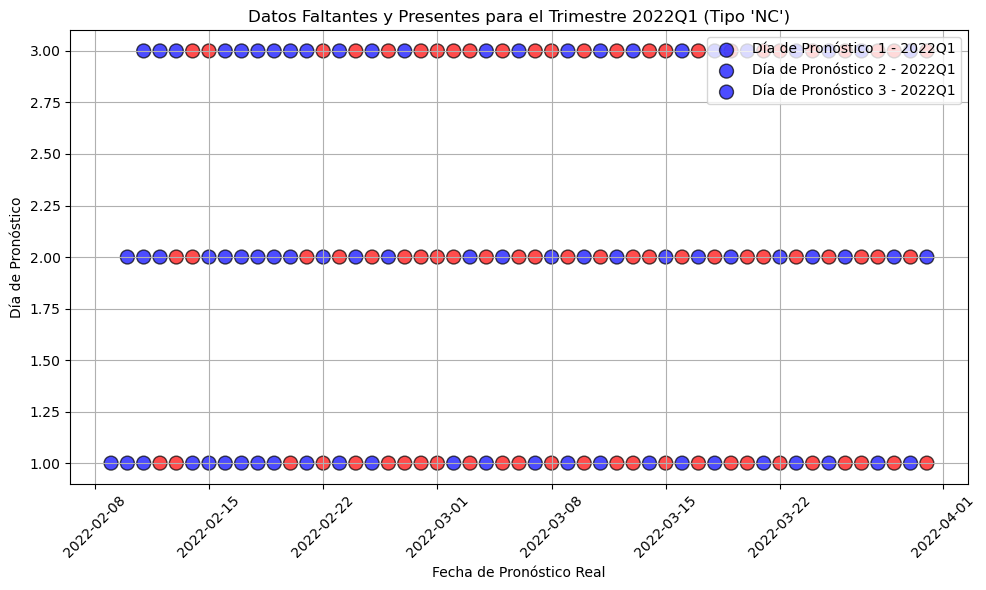

Gráfico guardado como scatter_plot_datos_faltantes_trimestre_2022Q1.png


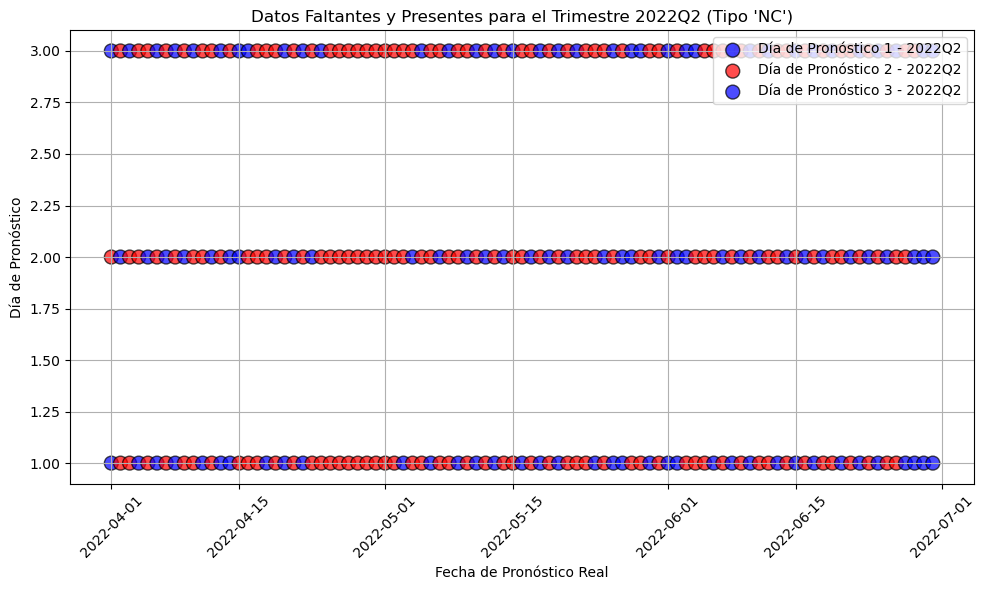

Gráfico guardado como scatter_plot_datos_faltantes_trimestre_2022Q2.png


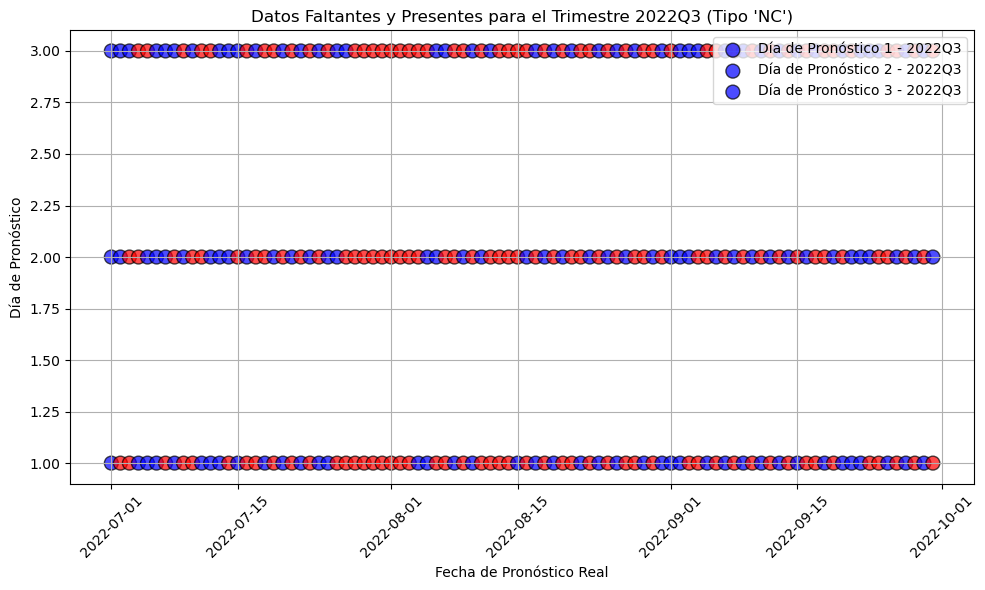

Gráfico guardado como scatter_plot_datos_faltantes_trimestre_2022Q3.png


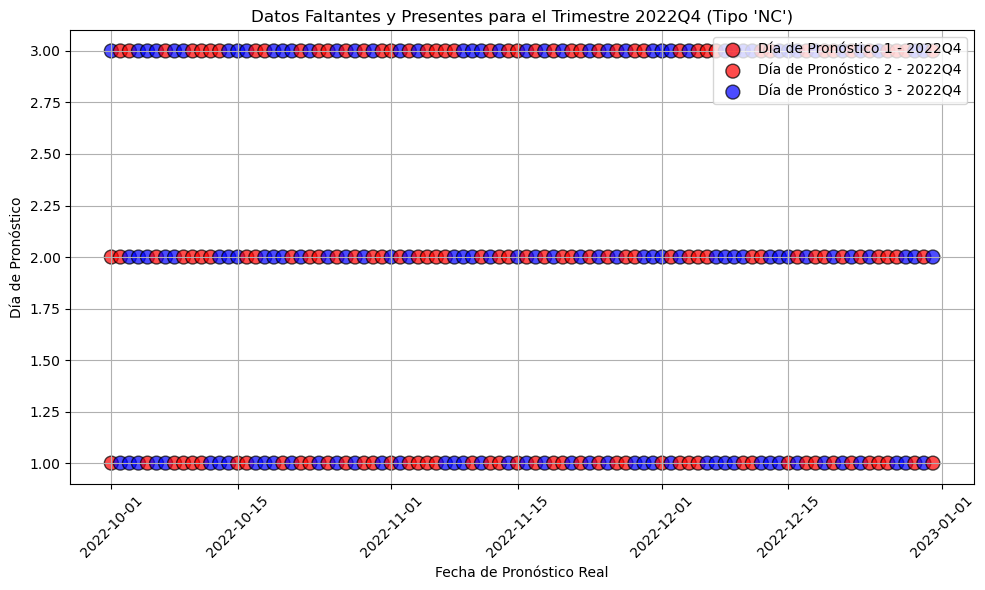

Gráfico guardado como scatter_plot_datos_faltantes_trimestre_2022Q4.png


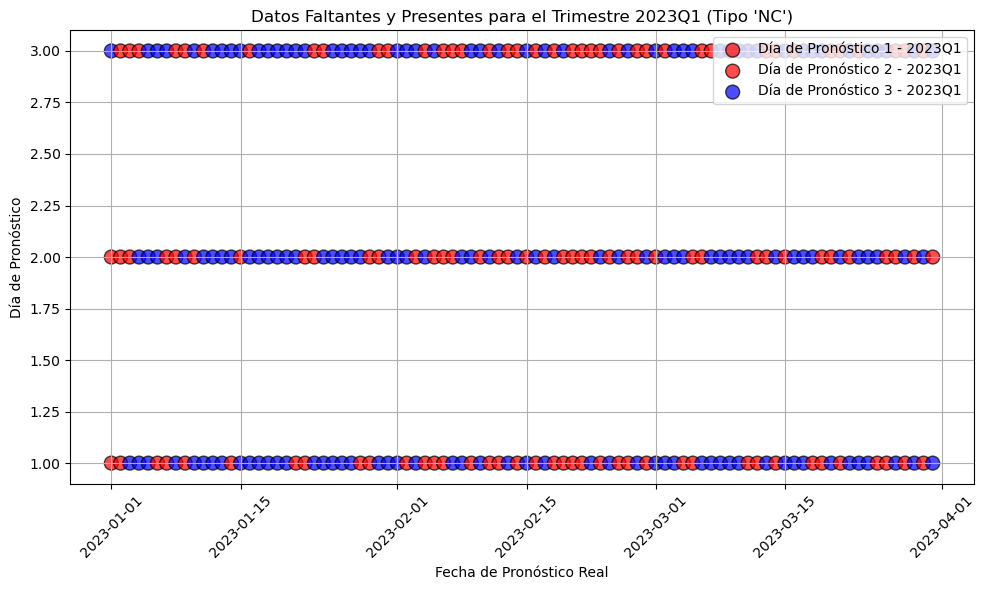

Gráfico guardado como scatter_plot_datos_faltantes_trimestre_2023Q1.png


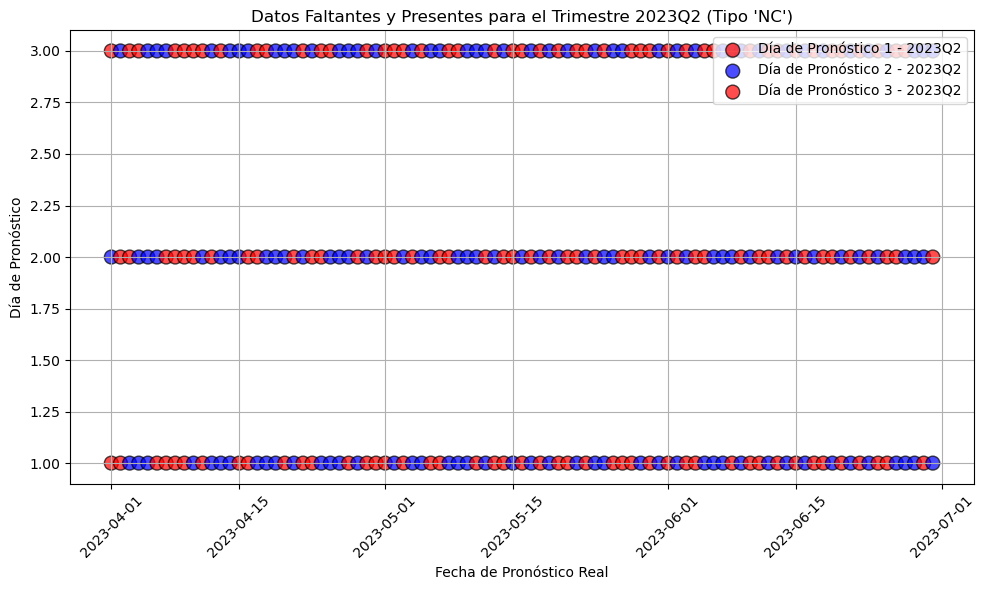

Gráfico guardado como scatter_plot_datos_faltantes_trimestre_2023Q2.png


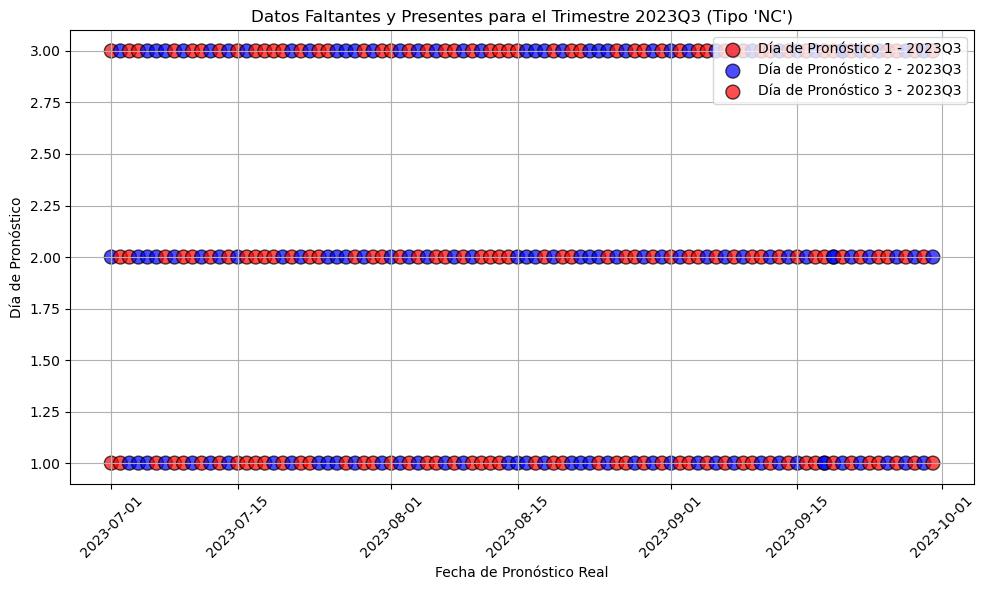

Gráfico guardado como scatter_plot_datos_faltantes_trimestre_2023Q3.png


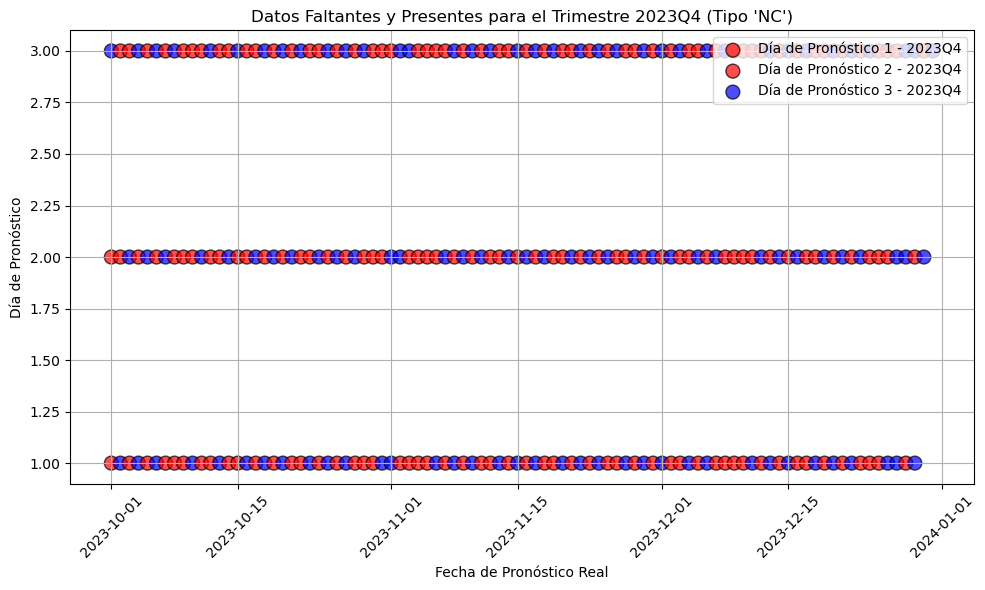

Gráfico guardado como scatter_plot_datos_faltantes_trimestre_2023Q4.png
Archivo NetCDF guardado como pronosticos_combinados.nc


In [15]:
import os
import rasterio
import numpy as np
import xarray as xr
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# Ruta base de los datos
base_path = "/Users/manuelnarvaez/Downloads/WRF"  # Cambia esta ruta a la ubicación de tus carpetas

# Definir los tipos esperados y los días de pronóstico
expected_types = ['nc']  # Graficaremos solo el tipo 'nc'
expected_days = [1, 2, 3]  # Primer, segundo y tercer día de pronóstico

# Función para obtener la fecha inicial del pronóstico desde el nombre del directorio
def get_start_date_from_path(path):
    try:
        # Extraer los componentes del path y buscar la carpeta que sigue el patrón "YYYY_MM_DD_00Z"
        path_parts = path.split(os.sep)
        for part in path_parts:
            if len(part.split('_')) == 4 and part.endswith('00Z'):
                year, month, day, _ = part.split('_')
                start_date = datetime(int(year), int(month), int(day))
                return start_date
    except Exception as e:
        print(f"No se pudo obtener la fecha inicial del pronóstico de la ruta: {path}. Error: {e}")
        return None

# Función para obtener el tipo y día de pronóstico desde el nombre del archivo
def get_forecast_info_from_filename(file_name, start_date):
    try:
        # Extraer el tipo y la fecha del archivo
        _, tipo, day_str, month_str, year_str = file_name.split('-')
        # Crear la fecha del archivo
        file_date = datetime(int(year_str.split('.')[0]), int(month_str), int(day_str))
        # Calcular el día de pronóstico relativo
        pronostico_day = (file_date - start_date).days + 1  
        return tipo, pronostico_day
    except Exception as e:
        print(f"No se pudo obtener la información del pronóstico del archivo: {file_name}. Error: {e}")
        return None, None

# Crear una lista para almacenar los datos
data_list = []

# Recorrer las carpetas dentro del directorio base
for root, dirs, files in os.walk(base_path):
    for file in files:
        if file.endswith(".tif"):
            # Obtener la fecha de inicio del pronóstico desde el path
            start_date = get_start_date_from_path(root)
            if start_date is None:
                continue
            
            # Obtener el tipo y el día de pronóstico desde el nombre del archivo
            tipo, pronostico_day = get_forecast_info_from_filename(file, start_date)
            if tipo is None or pronostico_day is None:
                continue
            
            # Ruta completa al archivo
            file_path = os.path.join(root, file)
            
            # Leer el archivo TIFF
            try:
                with rasterio.open(file_path) as src:
                    data = src.read(1)  # Leer la primera banda
                    transform = src.transform
                    meta = src.meta
            except Exception as e:
                print(f"No se pudo leer el archivo {file_path}. Error: {e}")
                continue
            
            # Almacenar la información en una lista
            data_list.append({
                'tipo': tipo,
                'start_date': start_date,
                'forecast_date': start_date + timedelta(days=pronostico_day - 1),
                'day_of_forecast': pronostico_day,
                'data': data,
                'transform': transform,
                'meta': meta,
                'file_path': file_path
            })

# Verificar si se han encontrado datos
if not data_list:
    print("No se encontraron archivos TIFF o las carpetas no tienen el formato esperado.")
    exit()

# Crear un DataFrame para organizar los datos disponibles
df = pd.DataFrame(data_list)

# Generar todas las fechas desde el primer al último pronóstico para asegurarnos de cubrir el rango completo
start_date_min = df['start_date'].min()
start_date_max = df['start_date'].max()
date_range = pd.date_range(start=start_date_min, end=start_date_max, freq='D')

# Crear un DataFrame con todas las combinaciones posibles para detectar faltantes
all_combinations = pd.MultiIndex.from_product(
    [date_range, expected_days, expected_types],
    names=['start_date', 'day_of_forecast', 'tipo']
)

# Crear un DataFrame para las combinaciones esperadas
df_all = pd.DataFrame(index=all_combinations).reset_index()

# Unir con el DataFrame de datos reales para detectar faltantes
df_full = pd.merge(df_all, df, on=['start_date', 'day_of_forecast', 'tipo'], how='left', indicator=True)

# Marcar como "Faltante" o "Presente"
df_full['status'] = np.where(df_full['_merge'] == 'both', 'Presente', 'No data')

# Eliminar columnas innecesarias
df_full = df_full.drop(columns=['data', 'transform', 'meta', 'file_path', '_merge'])

# Filtrar solo el tipo 'nc'
df_nc = df_full[df_full['tipo'] == 'nc'].copy()

# Calcular las fechas de pronóstico reales basadas en el día de pronóstico
df_nc['forecast_real_date'] = df_nc['start_date'] + pd.to_timedelta(df_nc['day_of_forecast'] - 1, unit='D')

# Función para crear un scatter plot de datos presentes y faltantes por trimestre
def plot_missing_data_scatter_per_quarter(df_nc):
    # Crear una columna con el trimestre
    df_nc['quarter'] = df_nc['forecast_real_date'].dt.to_period('Q')

    # Obtener los trimestres únicos
    quarters = df_nc['quarter'].unique()

    # Graficar cada trimestre por separado
    for quarter in quarters:
        df_quarter = df_nc[df_nc['quarter'] == quarter]

        plt.figure(figsize=(10, 6))
        # Graficar datos presentes y faltantes
        for day in expected_days:
            df_day = df_quarter[df_quarter['day_of_forecast'] == day]
            plt.scatter(df_day['forecast_real_date'], df_day['day_of_forecast'],
                        label=f'Día de Pronóstico {day} - {quarter}', 
                        c=df_day['status'].map({'Presente': 'blue', 'No data': 'red'}), 
                        marker='o', s=100, edgecolors='black', alpha=0.7)

        plt.title(f"Datos Faltantes y Presentes para el Trimestre {quarter} (Tipo 'NC')")
        plt.xlabel("Fecha de Pronóstico Real")
        plt.ylabel("Día de Pronóstico")
        plt.legend(loc='upper right')
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.tight_layout()
        
        # Guardar el gráfico como archivo PNG
        plt.savefig(f"scatter_plot_datos_faltantes_trimestre_{quarter}.png")
        plt.show()
        print(f"Gráfico guardado como scatter_plot_datos_faltantes_trimestre_{quarter}.png")

# Crear y guardar gráficos por trimestre para el tipo 'nc'
plot_missing_data_scatter_per_quarter(df_nc)

# Crear un DataArray de xarray con los datos TIFF organizados por día de pronóstico
arrays = []
for entry in data_list:
    arrays.append(xr.DataArray(
        entry['data'], 
        dims=("y", "x"), 
        coords={
            "forecast_date": entry['forecast_date'], 
            "day_of_forecast": entry['day_of_forecast'],
            "y": np.arange(entry['data'].shape[0]), 
            "x": np.arange(entry['data'].shape[1]), 
            "tipo": entry['tipo']
        }
    ))

# Concatenar todos los DataArrays en uno solo
combined_array = xr.concat(arrays, dim="day_of_forecast")

# Guardar el DataArray como un archivo NetCDF
netcdf_filename = "pronosticos_combinados.nc"
combined_array.to_netcdf(netcdf_filename)
print(f"Archivo NetCDF guardado como {netcdf_filename}")


In [2]:
import xarray as xr
netcdf=xr.open_dataset('/Users/manuelnarvaez/Documents/Python_Scripts/pronosticos_combinados.nc')
netcdf

<xarray.Dataset>
Dimensions:                        (day_of_forecast: 2898, y: 44, x: 40)
Coordinates:
    forecast_date                  (day_of_forecast) datetime64[ns] ...
  * day_of_forecast                (day_of_forecast) int64 1 1 3 2 2 ... 2 1 3 3
  * y                              (y) int64 0 1 2 3 4 5 6 ... 38 39 40 41 42 43
  * x                              (x) int64 0 1 2 3 4 5 6 ... 34 35 36 37 38 39
    tipo                           (day_of_forecast) object ...
Data variables:
    __xarray_dataarray_variable__  (day_of_forecast, y, x) float64 ...

In [3]:
firstday=netcdf.__xarray_dataarray_variable__.sel(day_of_forecast=1)
firstday

<xarray.DataArray '__xarray_dataarray_variable__' (day_of_forecast: 966, y: 44,
                                                   x: 40)>
[1700160 values with dtype=float64]
Coordinates:
    forecast_date    (day_of_forecast) datetime64[ns] ...
  * day_of_forecast  (day_of_forecast) int64 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
  * y                (y) int64 0 1 2 3 4 5 6 7 8 ... 35 36 37 38 39 40 41 42 43
  * x                (x) int64 0 1 2 3 4 5 6 7 8 ... 31 32 33 34 35 36 37 38 39
    tipo             (day_of_forecast) object ...

In [5]:
firstday.forecast_date

<xarray.DataArray 'forecast_date' (day_of_forecast: 966)>
[966 values with dtype=datetime64[ns]]
Coordinates:
    forecast_date    (day_of_forecast) datetime64[ns] ...
  * day_of_forecast  (day_of_forecast) int64 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
    tipo             (day_of_forecast) object ...

In [8]:
import rasterio
import xarray as xr
import rioxarray as rio

In [9]:
netcdf=rio.open_rasterio('/Users/manuelnarvaez/Downloads/WRF/2022/Abril/Boletín-1348-01-04-2022/2022_04_01_00Z/COE/tiff/RR/RR-c-01-04-2022.tif')
netcdf

<xarray.DataArray (band: 1, y: 44, x: 40)>
[1760 values with dtype=float64]
Coordinates:
  * band         (band) int64 1
    spatial_ref  int64 0
Dimensions without coordinates: y, x
Attributes:
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  2 (pixels/inch)
    TIFFTAG_SOFTWARE:        GrADS version 2.1.0.oga.1 
    TIFFTAG_XRESOLUTION:     0.21250001
    TIFFTAG_YRESOLUTION:     0.25
    scale_factor:            1.0
    add_offset:              0.0

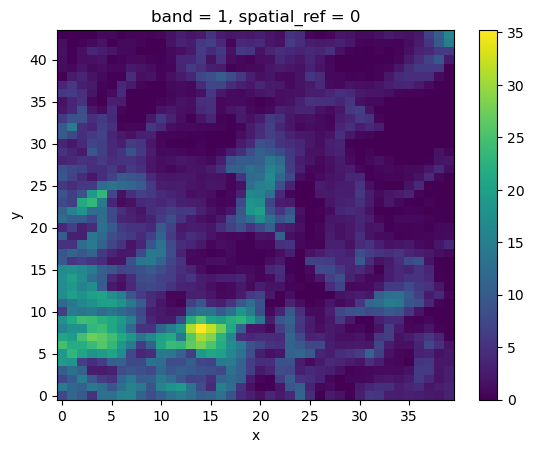

In [10]:
netcdf.isel(band=0).plot()

In [1]:
import os
import geopandas as gpd
import xarray as xr
import numpy as np
import pandas as pd
from rasterstats import zonal_stats
import rioxarray

# Ruta de la carpeta con archivos shapefile
shp_folder = "/Users/manuelnarvaez/Documents/DuniaConsultoria/Estaciones/Zonificacion"  # Cambiar a la ruta donde están los archivos shapefile
# Ruta del archivo NetCDF
netcdf_path = "/Users/manuelnarvaez/Documents/DuniaConsultoria/Estaciones/clima_final_final.nc"  # Cambiar a la ruta de tu archivo NetCDF

# Cargar el archivo NetCDF y renombrar dimensiones
ds_precip = xr.open_dataset(netcdf_path)

# Renombrar las dimensiones 'lat' y 'lon' a 'y' y 'x' para que coincidan con lo esperado
ds_precip = ds_precip.rename({'lat': 'y', 'lon': 'x'})

# Eliminar el atributo 'grid_mapping' si existe en cualquier variable
for var in ds_precip.data_vars:
    if 'grid_mapping' in ds_precip[var].attrs:
        del ds_precip[var].attrs['grid_mapping']

# Establecer las dimensiones espaciales para rioxarray
ds_precip.rio.set_spatial_dims(x_dim="x", y_dim="y", inplace=True)

# Asignar el sistema de coordenadas al NetCDF (ajusta si es necesario)
ds_precip.rio.write_crs("EPSG:4326", inplace=True)  # Asegúrate de que el CRS coincide con el de tu archivo NetCDF

# Crear una lista para almacenar los resultados
results = []

# Función para verificar si la geometría se superpone con los límites del raster
def geometry_within_bounds(geometry, ds):
    # Obtener límites del NetCDF
    minx, miny, maxx, maxy = ds.rio.bounds()
    # Obtener límites de la geometría
    geom_bounds = geometry.bounds
    # Verificar si la geometría está dentro de los límites del raster
    return not (geom_bounds[2] < minx or geom_bounds[0] > maxx or
                geom_bounds[3] < miny or geom_bounds[1] > maxy)

# Recorrer todos los archivos shapefile en la carpeta
for shp_file in os.listdir(shp_folder):
    if shp_file.endswith(".shp"):
        # Cargar el shapefile
        shp_path = os.path.join(shp_folder, shp_file)
        gdf = gpd.read_file(shp_path)
        
        # Transformar la proyección del shapefile a EPSG:4326 (Geographical WGS84)
        gdf = gdf.to_crs("EPSG:4326")
        
        # Recorrer cada geometría en el shapefile
        for idx, geometry in gdf.iterrows():
            # Verificar si la geometría se superpone con el raster
            if not geometry_within_bounds(geometry.geometry, ds_precip):
                print(f"Geometría {idx} de {shp_file} está fuera de los límites del raster.")
                continue
            
            # Crear una máscara para extraer datos de la región en la geometría
            for time_step in ds_precip.time:
                # Seleccionar datos de precipitación para el tiempo actual
                precip_slice = ds_precip.sel(time=time_step)
                
                # Guardar el archivo temporal de precipitación
                temp_raster = f"temp_precip_{time_step.dt.strftime('%Y%m%d').values}.tif"
                
                try:
                    precip_slice.Precipitacion.rio.to_raster(temp_raster)
                except Exception as e:
                    print(f"Error al guardar el raster para {time_step.dt.strftime('%Y-%m-%d').values}: {e}")
                    continue
                
                # Calcular estadísticas zonales usando el shapefile y el raster de precipitación
                try:
                    stats = zonal_stats(
                        geometry['geometry'], temp_raster, 
                        stats=['mean'], 
                        nodata=np.nan, 
                        geojson_out=True
                    )
                    
                    # Extraer la media de la precipitación ponderada para la geometría
                    mean_precip = stats[0]['properties']['mean']
                    
                    # Añadir los resultados a la lista
                    results.append({
                        'shapefile': shp_file,
                        'layer': idx,
                        'geometry_index': idx,
                        'time': time_step.values,
                        'mean_precip': mean_precip
                    })
                except Exception as e:
                    print(f"Error al calcular estadísticas zonales para {shp_file}, geometría {idx}: {e}")
                
                # Eliminar el archivo temporal
                if os.path.exists(temp_raster):
                    os.remove(temp_raster)

# Convertir resultados a un DataFrame
results_df = pd.DataFrame(results)

# Guardar el DataFrame con todas las series temporales
results_df.to_csv("resultados_media_ponderada.csv", index=False)
print("Series temporales guardadas en 'resultados_media_ponderada.csv'")


Error al calcular estadísticas zonales para H12_Thiessen_Regiones.shp, geometría 0: width and height must be > 0
Error al calcular estadísticas zonales para H12_Thiessen_Regiones.shp, geometría 0: width and height must be > 0
Error al calcular estadísticas zonales para H12_Thiessen_Regiones.shp, geometría 0: width and height must be > 0
Error al calcular estadísticas zonales para H12_Thiessen_Regiones.shp, geometría 0: width and height must be > 0
Error al calcular estadísticas zonales para H12_Thiessen_Regiones.shp, geometría 0: width and height must be > 0
Error al calcular estadísticas zonales para H12_Thiessen_Regiones.shp, geometría 0: width and height must be > 0
Error al calcular estadísticas zonales para H12_Thiessen_Regiones.shp, geometría 0: width and height must be > 0
Error al calcular estadísticas zonales para H12_Thiessen_Regiones.shp, geometría 0: width and height must be > 0
Error al calcular estadísticas zonales para H12_Thiessen_Regiones.shp, geometría 0: width and he

KeyboardInterrupt: 

In [55]:
import os
import geopandas as gpd
import xarray as xr
import pandas as pd
from rasterstats import zonal_stats
import rioxarray

# Ruta del archivo Shapefile
shapefile_path = "/Users/manuelnarvaez/Documents/DuniaConsultoria/Estaciones/Zonificacion/H5025_Thiessen_Regiones.shp"  # Cambia a la ruta de tu archivo shapefile
# Ruta del archivo NetCDF
netcdf_path = "/Users/manuelnarvaez/Documents/DuniaConsultoria/Estaciones/clima_final_final.nc"  # Cambia a la ruta de tu archivo NetCDF

# Cargar el archivo Shapefile usando GeoPandas
gdf = gpd.read_file(shapefile_path)

# Cargar el archivo NetCDF usando xarray
ds = xr.open_dataset(netcdf_path)

# Renombrar las dimensiones 'lat' y 'lon' a 'y' y 'x' para que coincidan con lo esperado por rioxarray
ds = ds.rename({'lat': 'y', 'lon': 'x'})

for var in ds.data_vars:
    if 'grid_mapping' in ds[var].attrs:
        del ds[var].attrs['grid_mapping']

# Establecer las dimensiones espaciales para rioxarray
ds.rio.set_spatial_dims(x_dim="x", y_dim="y", inplace=True)

# Asignar el sistema de coordenadas al NetCDF (ajusta si es necesario)
ds.rio.write_crs("EPSG:4326", inplace=True)

# Seleccionar la variable de interés
variable = 'Precipitacion'  # Cambia esto si la variable en el NetCDF tiene otro nombre

# Filtrar el rango de fechas deseado
fecha_inicio = '2018-06-21'
fecha_fin = '2023-12-31'
ds = ds.sel(time=slice(fecha_inicio, fecha_fin))

# Obtener la matriz de transformación (affine) desde las coordenadas del DataArray
transform = ds[variable].rio.transform()

# Lista para almacenar resultados
resultados = []

# Recorrer cada geometría en el shapefile
for idx, geometry in gdf.iterrows():
    geom = geometry['geometry']
    geom_id = geometry['Código']  # Cambia 'CC3digo' por el campo adecuado si es necesario

    # Crear una lista para almacenar los valores de precipitación ponderados
    serie_ponderada = []

    # Recortar el DataArray a la geometría actual
    ds_clipped = ds.rio.clip([geom], gdf.crs, drop=True)

    # Recorrer cada tiempo en el NetCDF y calcular la media ponderada dentro de la geometría
    for time in ds_clipped.time:
        # Seleccionar el dato de precipitación para el tiempo actual
        data_slice = ds_clipped[variable].sel(time=time)

        # Calcular la media ponderada de los valores de precipitación dentro de la geometría
        mean_precip = data_slice.mean().item()

        # Añadir el valor de precipitación ponderado a la lista
        serie_ponderada.append(mean_precip)

    # Crear un DataFrame para la serie temporal
    df_serie = pd.DataFrame({
        'Fecha': ds_clipped.time.values,
        'Precipitacion_Ponderada': serie_ponderada
    })

    # Guardar la serie en un archivo CSV
    output_csv = f"serie_ponderada_geom_{geom_id}.csv"
    df_serie.to_csv(output_csv, index=False)
    print(f"Serie temporal guardada en {output_csv}")

    # Añadir a la lista de resultados
    resultados.append(df_serie)

# Imprimir mensaje de finalización
print("Procesamiento completado para todas las geometrías.")



Serie temporal guardada en serie_ponderada_geom_M5076.csv
Serie temporal guardada en serie_ponderada_geom_C01.csv
Serie temporal guardada en serie_ponderada_geom_ATP02PT01.csv
Serie temporal guardada en serie_ponderada_geom_P39.csv
Serie temporal guardada en serie_ponderada_geom_M5124.csv
Serie temporal guardada en serie_ponderada_geom_ATP01PT02.csv
Serie temporal guardada en serie_ponderada_geom_ATP01PT01.csv
Procesamiento completado para todas las geometrías.


In [51]:
gdf

Id  Input_FID  No_ Código                Nombre Provincia Administra  \
0   0          1  5.0  M5025  La Virgen Papallacta      Napo      FONAG   

          X          Y       Z     Estado         F10         F11     Sistema  \
0  811859.0  9963068.0  4020.0  Operativa  2009-01-15  2023-12-31  Papallacta   

   Regiones                                           geometry  
0       1.0  POLYGON ((813520.308 9964327.767, 813520.308 9...

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, train_test_split
from tkinter import Tk, filedialog, simpledialog, messagebox
from matplotlib.backends.backend_pdf import PdfPages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, train_test_split
from matplotlib.backends.backend_pdf import PdfPages

# Función para generar intervalos de confianza y gráficos basados en percentiles
def confianza2(predictions, true_values, num_days=7):
    # Definir los percentiles que quieres en el eje X
    percentiles_x = [2.5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 97.5]
    percentiles_labels = ['P2.5', 'P10', 'P20', 'P30', 'P40', 'P50', 'P60', 'P70', 'P80', 'P90', 'P97.5']

    # Crear DataFrames para cada día y calcular percentiles y rangos en bucle
    dias_percentiles = {}

    # Obtener la serie real para comparación
    percentilesR = np.percentile(true_values, percentiles_x)

    for dia in range(1, num_days + 1):
        # Ordenar los valores del día 'dia' en las predicciones
        ordenados = pd.Series(predictions[:, dia - 1]).dropna().sort_values(ascending=True).reset_index(drop=True)

        # Crear un DataFrame para el día actual
        dia_df = pd.DataFrame({'Nombre': percentiles_labels})

        # Calcular los percentiles
        dia_df['percentiles'] = [np.percentile(ordenados, i) for i in percentiles_x]

        # Función para calcular los rangos C10, C90, C5, C95
        def calcular_rang(ordenados, percentil, percentiles_x):
            # Obtener el percentil anterior
            if percentil == percentiles_x[0]:
                p_anterior = 0  # Para el primer percentil, se puede usar 0 o un valor que no limite
            else:
                p_anterior = np.percentile(ordenados, percentiles_x[percentiles_x.index(percentil) - 1])

            # Filtrar los datos que son mayores que el percentil anterior
            p = ordenados[(ordenados <= np.percentile(ordenados, percentil)) & (ordenados > p_anterior)]

            # Calcular los percentiles
            c10 = np.percentile(p, 10) if len(p) > 0 else np.nan  # Verificar longitud para evitar errores
            c90 = np.percentile(p, 90) if len(p) > 0 else np.nan
            c5 = np.percentile(p, 5) if len(p) > 0 else np.nan
            c95 = np.percentile(p, 95) if len(p) > 0 else np.nan
            return c10, c90, c5, c95

        # Calcular los rangos para cada percentil y agregar al DataFrame
        dia_df[['C10', 'C90', 'C5', 'C95']] = [calcular_rang(ordenados, i, percentiles_x) for i in percentiles_x]

        # Guardar el DataFrame del día en el diccionario
        dias_percentiles[f'Dia_{dia}'] = dia_df

    # Guardar los gráficos en un archivo PDF
    pdf_filename = "intervalos_confianza_percentiles_por_dia.pdf"
    with PdfPages(pdf_filename) as pdf:
        # Graficar los percentiles y rangos para cada día
        for dia in range(1, num_days + 1):
            Dia = dias_percentiles[f'Dia_{dia}']

            plt.figure(figsize=(10, 6))
            plt.plot(Dia['Nombre'], percentilesR, label='Real', color='black', linewidth=1.5)

            # Graficar el intervalo de confianza para cada día
            plt.fill_between(Dia['Nombre'], Dia['C10'], Dia['C90'], color='blue', alpha=0.2, label='C10-C90')
            plt.fill_between(Dia['Nombre'], Dia['C5'], Dia['C95'], color='gray', alpha=0.2, label='C5-C95')

            # Etiquetas y título
            plt.title(f'Día {dia} - Intervalo de Confianza')
            plt.xlabel('Percentil')
            plt.ylabel('Valor Pronosticado')
            plt.grid(True)
            plt.legend(loc='upper left')

            # Guardar cada gráfico en el PDF
            pdf.savefig()
            plt.close()

    print(f"Gráficos guardados en el archivo PDF: {pdf_filename}")

    return dias_percentiles, percentilesR

# Función para seleccionar archivo CSV
def select_file():
    root = Tk()
    root.withdraw()  # Ocultar la ventana principal
    file_path = filedialog.askopenfilename(title="Selecciona el archivo CSV", filetypes=[("CSV files", "*.csv")])
    return file_path

# Función para seleccionar el header (columna)
def select_column(df, prompt):
    columns = df.columns.tolist()
    column = simpledialog.askstring("Input", f"{prompt}\nOpciones disponibles:\n" + "\n".join(columns))
    if column not in columns:
        print(f"Columna {column} no encontrada. Se usará la primera columna disponible: {columns[0]}")
        return columns[0]
    return column

# Función para seleccionar la cantidad de variables a tratar
def select_number_of_variables():
    root = Tk()
    root.withdraw()
    num_vars = simpledialog.askinteger("Input", "¿Cuántas variables deseas utilizar? (mínimo 2)")
    if num_vars is None or num_vars < 1:
        messagebox.showwarning("Advertencia", "Número inválido. Se utilizarán 2 variables por defecto.")
        return 2
    return num_vars

# Seleccionar cantidad de variables
num_vars = select_number_of_variables()

# Seleccionar archivos CSV
dataframes = []
column_names = []

for i in range(num_vars):
    file = select_file()
    df = pd.read_csv(file, parse_dates=['fecha'], index_col='fecha')
    column = select_column(df, f"Escribe el nombre de la columna de la variable {i+1}:")
    dataframes.append(df)
    column_names.append(column)

# Resamplear cada dataframe para obtener la media diaria
for i in range(num_vars):
    dataframes[i] = dataframes[i].resample('D').mean()

# Crear un DataFrame combinado con las variables seleccionadas
data_combined = pd.DataFrame(index=dataframes[0].index)

for i in range(num_vars):
    data_combined[column_names[i]] = dataframes[i][column_names[i]]

# Escalar los datos entre 0 y 1
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data_combined)

# Definir una ventana de tiempo más grande para entrenar (por ejemplo, 90 días)
window_size = 60

# Crear listas para guardar las métricas por cada día
metrics_test = {'RMSE': [], 'MAE': [], 'R²': []}
metrics_train = {'RMSE': [], 'MAE': [], 'R²': []}
best_params_per_day = []  # Lista para guardar los mejores parámetros por cada día

# Crear archivo PDF
pdf_filename = f'pronostico_svm3_netcdf_{num_vars}_variables_{"_".join(column_names)}.pdf'
with PdfPages(pdf_filename) as pdf:
    # Resumen de datos al inicio del PDF
    plt.figure(figsize=(8, 6))
    plt.text(0.5, 0.8, f'Variables Utilizadas en el Pronóstico:', ha='center', fontsize=14)
    plt.text(0.5, 0.7, f"{', '.join(column_names)}", ha='center', fontsize=12)
    plt.text(0.5, 0.6, f'Variable Pronosticada: {column_names[0]}', ha='center', fontsize=14)
    plt.axis('off')
    pdf.savefig()
    plt.close()

    for day in range(1, 8):
        # Separar datos en características (X) y objetivo (y) para cada día usando una ventana de tiempo grande
        X = []
        y = []
        for i in range(len(data_scaled) - window_size - day):
            X.append(data_scaled[i:(i + window_size), :])  # Tomar datos de la ventana de tiempo
            y.append(data_scaled[i + window_size + day - 1, 0])  # Predecir la primera variable `day` días en el futuro
        X = np.array(X)
        y = np.array(y)

        # Aplanar las características para que sean compatibles con SVM
        X = X.reshape(X.shape[0], -1)

        # Dividir los datos en conjunto de entrenamiento y prueba (80% - 20%)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

        # Crear un GridSearch para optimizar los hiperparámetros del SVM
        parameters = {
            'kernel': ['linear', 'poly', 'rbf','sigmoid'],
            'C': [0.01, 0.1, 1, 10,100],
            'gamma': ['scale', 'auto', 0.01, 0.1, 1],
            'coef0': [0.0, 0.1, 0.5],# Only relevant for 'poly' and 'sigmoid' kernels
            'shrinking': [True, False]
        }
        svr = SVR()
        grid_search = GridSearchCV(svr, parameters, cv=5, scoring='neg_mean_absolute_error', verbose=0, n_jobs=-1)
        grid_search.fit(X_train, y_train)

        # Mejor modelo encontrado por GridSearchCV
        best_svr = grid_search.best_estimator_

        # Guardar los mejores parámetros
        best_params_per_day.append(grid_search.best_params_)

        # Realizar el pronóstico para el día actual
        predictions_train = best_svr.predict(X_train)
        predictions_test = best_svr.predict(X_test)

        # Invertir el escalado para las predicciones y los valores reales
        y_train_unscaled = scaler.inverse_transform(np.concatenate([y_train.reshape(-1, 1), np.zeros((y_train.shape[0], num_vars - 1))], axis=1))[:, 0]
        y_test_unscaled = scaler.inverse_transform(np.concatenate([y_test.reshape(-1, 1), np.zeros((y_test.shape[0], num_vars - 1))], axis=1))[:, 0]
        predictions_train_unscaled = scaler.inverse_transform(np.concatenate([predictions_train.reshape(-1, 1), np.zeros((predictions_train.shape[0], num_vars - 1))], axis=1))[:, 0]
        predictions_test_unscaled = scaler.inverse_transform(np.concatenate([predictions_test.reshape(-1, 1), np.zeros((predictions_test.shape[0], num_vars - 1))], axis=1))[:, 0]


        #dias_percentiles, percentilesR = confianza2(y_test, predictions_test_unscaled)

        # Calcular métricas para el conjunto de prueba
        metrics_test['RMSE'].append(np.sqrt(mean_squared_error(y_test_unscaled, predictions_test_unscaled)))
        metrics_test['MAE'].append(mean_absolute_error(y_test_unscaled, predictions_test_unscaled))
        metrics_test['R²'].append(r2_score(y_test_unscaled, predictions_test_unscaled))

        # Calcular métricas para el conjunto de entrenamiento
        metrics_train['RMSE'].append(np.sqrt(mean_squared_error(y_train_unscaled, predictions_train_unscaled)))
        metrics_train['MAE'].append(mean_absolute_error(y_train_unscaled, predictions_train_unscaled))
        metrics_train['R²'].append(r2_score(y_train_unscaled, predictions_train_unscaled))

        # Guardar resultados de prueba en archivo CSV
        df_results = pd.DataFrame({
            'Fecha': data_combined.index[-len(y_test_unscaled):],
            'Valor Real': y_test_unscaled,
            'Pronóstico': predictions_test_unscaled
        })
        df_results.to_csv(f'predicciones_svm_dia_{day}.csv', index=False)
        print(f'Datos del día {day} guardados en "predicciones_svm_dia_{day}.csv"')

        # Gráfico de predicción vs realidad para el conjunto de prueba
        plt.figure(figsize=(10, 5))
        plt.plot(data_combined.index[-len(y_test_unscaled):], y_test_unscaled, label=f'Valor Real Prueba (Día {day})', color='green')
        plt.plot(data_combined.index[-len(y_test_unscaled):], predictions_test_unscaled, label=f'Pronóstico Prueba (Día {day})', color='red')
        plt.title(f'Pronóstico vs Valor Real - Día {day} (Prueba)')
        plt.xlabel('Fecha')
        plt.ylabel(column_names[0])  # Mostrar nombre de la primera variable
        plt.legend()
        plt.grid(True)
        plt.figtext(0.15, 0.15, f"Test RMSE: {metrics_test['RMSE'][-1]:.4f}, Test MAE: {metrics_test['MAE'][-1]:.4f}, Test R²: {metrics_test['R²'][-1]:.4f}", fontsize=10, ha='left')
        pdf.savefig()
        plt.close()

        # Gráfico de predicción vs realidad para el conjunto de entrenamiento
        plt.figure(figsize=(10, 5))
        plt.plot(data_combined.index[:len(y_train_unscaled)], y_train_unscaled, label=f'Valor Real Entrenamiento (Día {day})', color='blue')
        plt.plot(data_combined.index[:len(y_train_unscaled)], predictions_train_unscaled, label=f'Pronóstico Entrenamiento (Día {day})', color='cyan')
        plt.title(f'Pronóstico vs Valor Real - Día {day} (Entrenamiento)')
        plt.xlabel('Fecha')
        plt.ylabel(column_names[0])  # Mostrar nombre de la primera variable
        plt.legend()
        plt.grid(True)
        plt.figtext(0.15, 0.15, f"Train RMSE: {metrics_train['RMSE'][-1]:.4f}, Train MAE: {metrics_train['MAE'][-1]:.4f}, Train R²: {metrics_train['R²'][-1]:.4f}", fontsize=10, ha='left')
        pdf.savefig()
        plt.close()

        # Guardar los mejores parámetros del día en el PDF
        plt.figure(figsize=(8, 6))
        plt.text(0.5, 0.5, f'Mejor Modelo Día {day}:\n{grid_search.best_params_}', ha='center', fontsize=12)
        plt.axis('off')
        pdf.savefig()
        plt.close()

    # Gráfico resumen de métricas por día
    plt.figure(figsize=(10, 5))
    days = range(1, 8)
    plt.plot(days, metrics_test['RMSE'], label='Test RMSE', marker='o')
    plt.plot(days, metrics_test['MAE'], label='Test MAE', marker='o')
    plt.plot(days, metrics_test['R²'], label='Test R²', marker='o')
    plt.title('Métricas de Pronóstico para Cada Día (Conjunto de Prueba)')
    plt.xlabel('Día de Pronóstico')
    plt.ylabel('Métrica')
    plt.legend()
    plt.grid(True)
    pdf.savefig()
    plt.close()

# Mensaje de finalización
print(f"Resultados y gráficos guardados en el archivo {pdf_filename}.")


2024-10-15 13:50:03.649 python[99202:3311733] +[IMKClient subclass]: chose IMKClient_Legacy
2024-10-15 13:50:03.649 python[99202:3311733] +[IMKInputSession subclass]: chose IMKInputSession_Legacy
2024-10-15 13:50:07.217 python[99202:3311733] The class 'NSOpenPanel' overrides the method identifier.  This method is implemented by class 'NSWindow'
/var/folders/ld/lp18grh57gj_zwvnvgvp7cl40000gp/T/ipykernel_99202/3198575155.py:129: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(file, parse_dates=['fecha'], index_col='fecha')
/var/folders/ld/lp18grh57gj_zwvnvgvp7cl40000gp/T/ipykernel_99202/3198575155.py:129: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(file, parse_dates=['fecha'], in

Datos del día 1 guardados en "predicciones_svm_dia_1.csv"
Datos del día 2 guardados en "predicciones_svm_dia_2.csv"
Datos del día 3 guardados en "predicciones_svm_dia_3.csv"
Datos del día 4 guardados en "predicciones_svm_dia_4.csv"
Datos del día 5 guardados en "predicciones_svm_dia_5.csv"
Datos del día 6 guardados en "predicciones_svm_dia_6.csv"
Datos del día 7 guardados en "predicciones_svm_dia_7.csv"
Resultados y gráficos guardados en el archivo pronostico_svm3_netcdf_4_variables_H12_5025_ATP01PT02_M5124.pdf.


In [12]:
import os
import rasterio
import numpy as np
import xarray as xr
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# Ruta del archivo Excel que contiene los datos "Presentes"
excel_path = "/Users/manuelnarvaez/Documents/DuniaConsultoria/Estaciones/Pronosticos_graficas.xlsx"
# Cargar el archivo Excel con la hoja adecuada
df_excel = pd.read_excel(excel_path, sheet_name="tabla_dia_1_pronostico")

# Filtrar solo las filas que tienen 'Presente' en las columnas 'a', 'b', 'c'
df_excel_filtered = df_excel[['forecast_real_date', 'a', 'b', 'c']].copy()

# Convertir forecast_real_date a formato de fecha si no lo está
df_excel_filtered['forecast_real_date'] = pd.to_datetime(df_excel_filtered['forecast_real_date'], errors='coerce')

# Ruta base de los datos
base_path = "/Users/manuelnarvaez/Downloads/WRF"  # Cambia esta ruta a la ubicación de tus carpetas

# Definir los tipos esperados y los días de pronóstico
expected_types = ['c', 'e', 'nc']
expected_days = [1, 2, 3]  # Primer, segundo y tercer día de pronóstico

# Función para obtener la fecha inicial del pronóstico desde el nombre del directorio
def get_start_date_from_path(path):
    try:
        # Extraer los componentes del path y buscar la carpeta que sigue el patrón "YYYY_MM_DD_00Z"
        path_parts = path.split(os.sep)
        for part in path_parts:
            if len(part.split('_')) == 4 and part.endswith('00Z'):
                year, month, day, _ = part.split('_')
                start_date = datetime(int(year), int(month), int(day))
                return start_date
    except Exception as e:
        print(f"No se pudo obtener la fecha inicial del pronóstico de la ruta: {path}. Error: {e}")
        return None

# Función para obtener el tipo y día de pronóstico desde el nombre del archivo
def get_forecast_info_from_filename(file_name, start_date):
    try:
        # Extraer el tipo y la fecha del archivo, solo si comienza con "RR"
        if not file_name.startswith("RR"):
            return None, None
        _, tipo, day_str, month_str, year_str = file_name.split('-')
        # Crear la fecha del archivo
        file_date = datetime(int(year_str.split('.')[0]), int(month_str), int(day_str))
        # Calcular el día de pronóstico relativo
        pronostico_day = (file_date - start_date).days + 1  
        return tipo, pronostico_day
    except Exception as e:
        print(f"No se pudo obtener la información del pronóstico del archivo: {file_name}. Error: {e}")
        return None, None

# Crear una lista para almacenar los datos
data_list = []

# Recorrer las carpetas dentro del directorio base
for root, dirs, files in os.walk(base_path):
    for file in files:
        if file.endswith(".tif"):
            # Obtener la fecha de inicio del pronóstico desde el path
            start_date = get_start_date_from_path(root)
            if start_date is None:
                continue
            
            # Obtener el tipo y el día de pronóstico desde el nombre del archivo
            tipo, pronostico_day = get_forecast_info_from_filename(file, start_date)
            if tipo is None or pronostico_day is None:
                continue
            
            # Ruta completa al archivo
            file_path = os.path.join(root, file)
            
            # Leer el archivo TIFF
            try:
                with rasterio.open(file_path) as src:
                    data = src.read(1)  # Leer la primera banda
                    transform = src.transform
                    meta = src.meta
            except Exception as e:
                print(f"No se pudo leer el archivo {file_path}. Error: {e}")
                continue
            
            # Verificar si el archivo está presente en el Excel en el día correspondiente
            forecast_real_date = start_date + timedelta(days=pronostico_day - 1)
            
            # Mapear los días de pronóstico con las nuevas columnas
            column_map = {1: 'a', 2: 'b', 3: 'c'}
            column_day = column_map[pronostico_day]  # Acceder a la columna correcta ('a', 'b', 'c')

            # Filtrar el DataFrame Excel por fecha y presencia en la columna correspondiente
            df_filtered_day = df_excel_filtered[(df_excel_filtered['forecast_real_date'] == forecast_real_date) & 
                                                (df_excel_filtered[column_day] == 'Presente')]
            
            if df_filtered_day.empty:
                continue  # Si no está en el Excel como presente para ese día, se ignora
            
            # Almacenar la información en una lista
            data_list.append({
                'tipo': tipo,
                'start_date': start_date,
                'forecast_date': forecast_real_date,
                'day_of_forecast': pronostico_day,
                'data': data,
                'transform': transform,
                'meta': meta,
                'file_path': file_path
            })

# Verificar si se han encontrado datos
if not data_list:
    print("No se encontraron archivos TIFF con el formato 'RR' o no están presentes en el Excel.")
    exit()

# Crear un DataArray de xarray con los datos TIFF organizados por día de pronóstico
arrays_by_day = {1: [], 2: [], 3: []}

for entry in data_list:
    data_array = xr.DataArray(
        entry['data'], 
        dims=("y", "x"), 
        coords={
            "forecast_date": entry['forecast_date'], 
            "day_of_forecast": entry['day_of_forecast'],
            "y": np.arange(entry['data'].shape[0]), 
            "x": np.arange(entry['data'].shape[1]), 
            "tipo": entry['tipo']
        }
    )
    arrays_by_day[entry['day_of_forecast']].append(data_array)

# Guardar un archivo NetCDF para cada día de pronóstico
for day, arrays in arrays_by_day.items():
    if arrays:
        combined_array = xr.concat(arrays, dim="forecast_date")
        netcdf_filename = f"pronostico_dia_{day}.nc"
        combined_array.to_netcdf(netcdf_filename)
        print(f"Archivo NetCDF para el día {day} guardado como {netcdf_filename}")


Archivo NetCDF para el día 1 guardado como pronostico_dia_1.nc
Archivo NetCDF para el día 2 guardado como pronostico_dia_2.nc
Archivo NetCDF para el día 3 guardado como pronostico_dia_3.nc


In [14]:
ncfile=xr.open_dataset('/Users/manuelnarvaez/Documents/Python_Scripts/pronostico_dia_1.nc')
ncfile

<xarray.Dataset>
Dimensions:                        (forecast_date: 966, y: 44, x: 40)
Coordinates:
  * forecast_date                  (forecast_date) datetime64[ns] 2022-11-11 ...
    day_of_forecast                int64 ...
  * y                              (y) int64 0 1 2 3 4 5 6 ... 38 39 40 41 42 43
  * x                              (x) int64 0 1 2 3 4 5 6 ... 34 35 36 37 38 39
    tipo                           (forecast_date) object ...
Data variables:
    __xarray_dataarray_variable__  (forecast_date, y, x) float64 ...

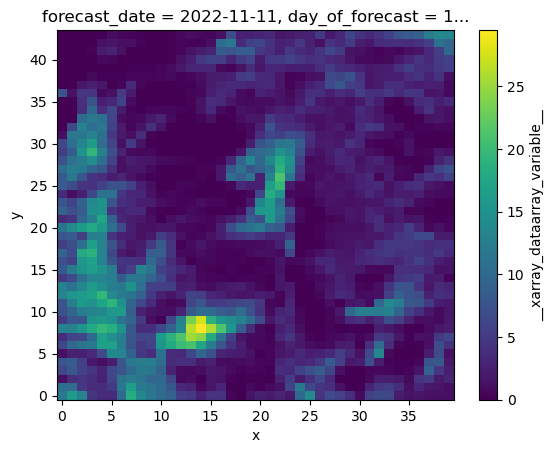

In [16]:
ncfile.__xarray_dataarray_variable__.isel(forecast_date=1).plot()

In [25]:
import os
import rasterio
import numpy as np
import xarray as xr
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# Definir los parámetros geográficos
extent = [-79.0182230000000203, -0.8239348679942970, -77.9743880290961187, 0.3242836000000000]
pixel_size = [0.02609587427259766126, -0.02609587427259766126]
origin = [-79.0182230000000203, 0.3242836000000000]
width = 40
height = 44

# Definir las coordenadas de latitud y longitud
latitudes = np.linspace(origin[1], origin[1] + pixel_size[1] * height, height)
longitudes = np.linspace(origin[0], origin[0] + pixel_size[0] * width, width)

# Ruta del archivo Excel que contiene los datos "Presentes"
excel_path = "/Users/manuelnarvaez/Documents/DuniaConsultoria/Estaciones/Pronosticos_graficas.xlsx"
# Cargar el archivo Excel con la hoja adecuada
df_excel = pd.read_excel(excel_path, sheet_name="tabla_dia_1_pronostico")

# Filtrar solo las filas que tienen 'Presente' en las columnas 'a', 'b', 'c'
df_excel_filtered = df_excel[['forecast_real_date', 'a', 'b', 'c']].copy()

# Convertir forecast_real_date a formato de fecha si no lo está
df_excel_filtered['forecast_real_date'] = pd.to_datetime(df_excel_filtered['forecast_real_date'], errors='coerce')

# Ruta base de los datos
base_path = "/Users/manuelnarvaez/Downloads/WRF"  # Cambia esta ruta a la ubicación de tus carpetas

# Definir el único tipo esperado: 'c'
expected_type = 'c'

# Función para obtener la fecha inicial del pronóstico desde el nombre del directorio
def get_start_date_from_path(path):
    try:
        # Extraer los componentes del path y buscar la carpeta que sigue el patrón "YYYY_MM_DD_00Z"
        path_parts = path.split(os.sep)
        for part in path_parts:
            if len(part.split('_')) == 4 and part.endswith('00Z'):
                year, month, day, _ = part.split('_')
                start_date = datetime(int(year), int(month), int(day))
                return start_date
    except Exception as e:
        print(f"No se pudo obtener la fecha inicial del pronóstico de la ruta: {path}. Error: {e}")
        return None

# Función para obtener el tipo y día de pronóstico desde el nombre del archivo
def get_forecast_info_from_filename(file_name, start_date):
    try:
        # Solo procesar archivos que comienzan con "RR-c"
        if not file_name.startswith("RR-c"):
            return None, None
        
        # El archivo tiene la fecha del primer día, pero los otros dos días no están en el nombre
        # El nombre contiene el formato 'RR-c-01-01-2022.tif', donde '01-01-2022' es el primer día.
        _, tipo, day_str, month_str, year_str = file_name.split('-')
        file_date = datetime(int(year_str.split('.')[0]), int(month_str), int(day_str))

        # Calcular el día de pronóstico relativo
        if file_date == start_date:
            pronostico_day = 1  # Primer día
        elif file_date == start_date + timedelta(days=1):
            pronostico_day = 2  # Segundo día
        elif file_date == start_date + timedelta(days=2):
            pronostico_day = 3  # Tercer día
        else:
            return None, None  # Si la fecha no corresponde a ninguno de los tres días

        return tipo, pronostico_day
    except Exception as e:
        print(f"No se pudo obtener la información del pronóstico del archivo: {file_name}. Error: {e}")
        return None, None


# Crear una lista para almacenar los datos
data_list = []

# Recorrer las carpetas dentro del directorio base
# Recorrer las carpetas dentro del directorio base
for root, dirs, files in os.walk(base_path):
    print(f"Procesando carpeta: {root}")  # Agregar esta línea para depuración
    for file in files:
        print(f"Archivo encontrado: {file}")  # Depurar los archivos encontrados
        if file.endswith(".tif"):
            # Obtener la fecha de inicio del pronóstico desde el path
            start_date = get_start_date_from_path(root)
            if start_date is None:
                continue
            
            # Obtener el tipo y el día de pronóstico desde el nombre del archivo
            tipo, pronostico_day = get_forecast_info_from_filename(file, start_date)
            if tipo is None or pronostico_day is None or tipo != expected_type:
                continue
            
            # Ruta completa al archivo
            file_path = os.path.join(root, file)
            
            # Leer el archivo TIFF
            try:
                with rasterio.open(file_path) as src:
                    data = src.read(1)  # Leer la primera banda
                    transform = src.transform
                    meta = src.meta
            except Exception as e:
                print(f"No se pudo leer el archivo {file_path}. Error: {e}")
                continue
            
            # Verificar si el archivo está presente en el Excel en el día correspondiente
            forecast_real_date = start_date + timedelta(days=pronostico_day - 1)
            
            # Mapear los días de pronóstico con las nuevas columnas
            column_map = {1: 'a', 2: 'b', 3: 'c'}
            column_day = column_map[pronostico_day]  # Acceder a la columna correcta ('a', 'b', 'c')

            # Filtrar el DataFrame Excel por fecha y presencia en la columna correspondiente
            df_filtered_day = df_excel_filtered[(df_excel_filtered['forecast_real_date'] == forecast_real_date) & 
                                                (df_excel_filtered[column_day] == 'Presente')]
            
            if df_filtered_day.empty:
                continue  # Si no está en el Excel como presente para ese día, se ignora
            
            # Almacenar la información en una lista
            data_list.append({
                'tipo': tipo,
                'start_date': start_date,
                'forecast_date': forecast_real_date,
                'day_of_forecast': pronostico_day,
                'data': data,
                'transform': transform,
                'meta': meta,
                'file_path': file_path
            })
            print(f"Fecha pronóstico calculada: {forecast_real_date} para el archivo {file}")



# Verificar si se han encontrado datos
if not data_list:
    print("No se encontraron archivos TIFF con el formato 'RR-c' o no están presentes en el Excel.")
    exit()

# Crear un DataArray de xarray con los datos TIFF organizados por día de pronóstico y asignar las latitudes y longitudes
arrays_by_day = {1: [], 2: [], 3: []}

for entry in data_list:
    data_array = xr.DataArray(
        entry['data'], 
        dims=("lat", "lon"), 
        coords={
            "forecast_date": entry['forecast_date'], 
            "day_of_forecast": entry['day_of_forecast'],
            "lat": latitudes,  # Asignar latitudes
            "lon": longitudes,  # Asignar longitudes
            "tipo": entry['tipo']
        },
        name="precipitacion"  # Cambiar el nombre de la variable a "precipitacion"
    )
    arrays_by_day[entry['day_of_forecast']].append(data_array)

# Guardar un archivo NetCDF para cada día de pronóstico
for day, arrays in arrays_by_day.items():
    if arrays:
        # Concatenar todos los arrays por la dimensión 'forecast_date'
        combined_array = xr.concat(arrays, dim="forecast_date")
        
        # Ordenar el DataArray por la fecha del pronóstico (forecast_date)
        combined_array = combined_array.sortby("forecast_date")
        
        # Guardar el archivo NetCDF con los datos ordenados por fecha
        netcdf_filename = f"pronostico_dia_{day}.nc"
        combined_array.to_netcdf(netcdf_filename)
        print(f"Archivo NetCDF para el día {day} guardado como {netcdf_filename}")



Procesando carpeta: /Users/manuelnarvaez/Downloads/WRF
Archivo encontrado: .DS_Store
Procesando carpeta: /Users/manuelnarvaez/Downloads/WRF/2022
Archivo encontrado: .DS_Store
Procesando carpeta: /Users/manuelnarvaez/Downloads/WRF/2022/Noviembre
Procesando carpeta: /Users/manuelnarvaez/Downloads/WRF/2022/Noviembre/Boletín-1437-11-11-2022
Archivo encontrado: Boletín-1437-11-11-2022.tex
Archivo encontrado: Boletín-1437-11-11-2022.pdf
Procesando carpeta: /Users/manuelnarvaez/Downloads/WRF/2022/Noviembre/Boletín-1437-11-11-2022/.Estatico
Archivo encontrado: estaciones.png
Archivo encontrado: logo2021.png
Archivo encontrado: barra.pdf
Archivo encontrado: estaciones2019.png
Procesando carpeta: /Users/manuelnarvaez/Downloads/WRF/2022/Noviembre/Boletín-1437-11-11-2022/2022_11_11_00Z
Archivo encontrado: geast.jpg
Archivo encontrado: nc-valles.pdf
Archivo encontrado: c-valles.pdf
Archivo encontrado: c-sur.pdf
Archivo encontrado: nc-epmaps2-compara2-1111.pdf
Archivo encontrado: c-epmaps2-comp

In [12]:
df_excel

forecast_real_date         a         b         c
0           2022-02-09  Presente       NaN       NaN
1           2022-02-10  Presente  Presente       NaN
2           2022-02-11  Presente  Presente  Presente
3           2022-02-12       NaN  Presente  Presente
4           2022-02-13       NaN       NaN  Presente
..                 ...       ...       ...       ...
686         2023-12-27  Presente  Presente       NaN
687         2023-12-28       NaN  Presente  Presente
688         2023-12-29  Presente       NaN  Presente
689         2023-12-30       NaN  Presente       NaN
690         2023-12-31       NaN       NaN  Presente

[691 rows x 4 columns]

In [27]:
ncfile=xr.open_dataset('/Users/manuelnarvaez/Documents/Python_Scripts/pronostico_dia_3.nc')

ncfile

<xarray.Dataset>
Dimensions:          (forecast_date: 322, lat: 44, lon: 40)
Coordinates:
  * forecast_date    (forecast_date) datetime64[ns] 2022-02-11 ... 2023-12-31
    day_of_forecast  int64 ...
  * lat              (lat) float64 0.3243 0.2976 0.2709 ... -0.7972 -0.8239
  * lon              (lon) float64 -79.02 -78.99 -78.96 ... -78.03 -78.0 -77.97
    tipo             object ...
Data variables:
    precipitacion    (forecast_date, lat, lon) float64 ...

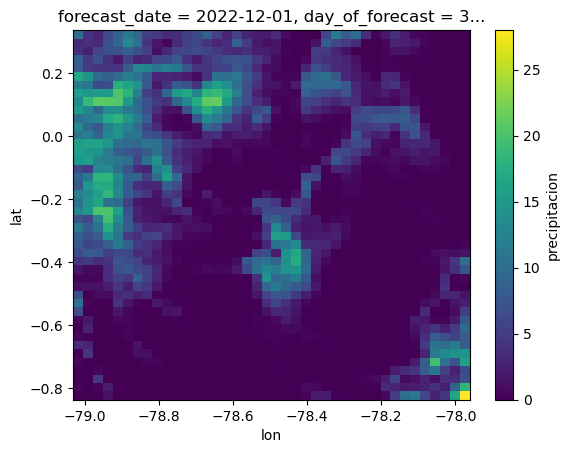

In [44]:
ncfile.precipitacion.isel(forecast_date=3).plot()

In [35]:
ncfile.tipo

<xarray.DataArray 'tipo' (forecast_date: 966)>
[966 values with dtype=object]
Coordinates:
  * forecast_date    (forecast_date) datetime64[ns] 2022-11-11 ... 2023-12-27
    day_of_forecast  int64 ...
    tipo             (forecast_date) object ...

In [1]:
import geopandas as gpd
import xarray as xr
import pandas as pd
from datetime import timedelta

# Función para cargar un NetCDF y extraer la serie de precipitación por latitud y longitud
def extract_series_from_netcdf(netcdf_file, lat, lon):
    ds = xr.open_dataset(netcdf_file)
    # Seleccionar la ubicación más cercana a la lat/lon proporcionada
    precip_series = ds['precipitacion'].sel(lat=lat, lon=lon, method='nearest').to_pandas()
    return precip_series

# Función para identificar el rango completo de fechas en los archivos NetCDF
def get_date_range_from_netcdf(netcdf_files):
    min_date = None
    max_date = None
    for netcdf_file in netcdf_files:
        ds = xr.open_dataset(netcdf_file)
        dates = ds['forecast_date'].to_pandas()  # Obtener las fechas del NetCDF
        if min_date is None or dates.min() < min_date:
            min_date = dates.min()
        if max_date is None or dates.max() > max_date:
            max_date = dates.max()
    # Sumar 2 días al max_date
    max_date = max_date + timedelta(days=2)
    return min_date, max_date

# Función para crear una serie completa de fechas dentro del rango dado
def create_complete_date_series(min_date, max_date):
    return pd.date_range(start=min_date, end=max_date)

# Función para procesar todas las estaciones del shapefile
def process_stations_and_save_series(shapefile_path, netcdf_files):
    # Transformar el shapefile a WGS84 y leerlo
    gdf = gpd.read_file(shapefile_path).to_crs(epsg=4326)
    
    # Identificar el rango completo de fechas en los archivos NetCDF
    min_date, max_date = get_date_range_from_netcdf(netcdf_files)
    
    # Crear una serie completa de fechas dentro de ese rango
    complete_date_series = create_complete_date_series(min_date, max_date)
    
    # Iterar sobre cada estación en el shapefile
    for index, row in gdf.iterrows():
        station_name = row['Código']  # Ajuste para usar la columna 'Código'
        lat = row.geometry.y  # Obtener la latitud
        lon = row.geometry.x  # Obtener la longitud
        
        # Crear un DataFrame vacío con la serie completa de fechas
        df_station = pd.DataFrame({'Fecha': complete_date_series})

        # Extraer la serie de cada NetCDF para el día 1, 2 y 3
        for day, netcdf_file in enumerate(netcdf_files, start=1):
            series = extract_series_from_netcdf(netcdf_file, lat, lon)
            df_series = pd.DataFrame({'Fecha': series.index, f'Pronostico_Dia_{day}': series.values})
            
            # Combinar la serie con el DataFrame principal por fecha (outer join)
            df_station = pd.merge(df_station, df_series, on='Fecha', how='left')  # Combinar series por fecha
        
        # Ordenar el DataFrame por fecha (esto se hace automáticamente, pero lo mantenemos por seguridad)
        df_station.sort_values(by='Fecha', inplace=True)

        # Guardar el DataFrame en un archivo CSV con el formato "wrf_[nombre de la estación]_serie.csv"
        csv_filename = f'wrf_{station_name}_serie.csv'
        df_station.to_csv(csv_filename, index=False)
        print(f"Archivo guardado: {csv_filename}")

# Lista de archivos NetCDF (uno por día de pronóstico)
netcdf_files = ['pronostico_dia_1.nc', 'pronostico_dia_2.nc', 'pronostico_dia_3.nc']

# Ruta al shapefile que contiene los puntos de las estaciones
shapefile_path = '/Users/manuelnarvaez/Documents/Estaciones/Estaciones_Precipitación.shp'

# Llamar a la función para procesar las estaciones y guardar las series
process_stations_and_save_series(shapefile_path, netcdf_files)


Archivo guardado: wrf_M5021_serie.csv
Archivo guardado: wrf_M5022_serie.csv
Archivo guardado: wrf_M5023_serie.csv
Archivo guardado: wrf_M5024_serie.csv
Archivo guardado: wrf_M5025_serie.csv
Archivo guardado: wrf_M5074_serie.csv
Archivo guardado: wrf_M5075_serie.csv
Archivo guardado: wrf_M5179_serie.csv
Archivo guardado: wrf_C12_serie.csv
Archivo guardado: wrf_P57_serie.csv
Archivo guardado: wrf_C13_serie.csv
Archivo guardado: wrf_P37_serie.csv
Archivo guardado: wrf_C16_serie.csv
Archivo guardado: wrf_P34_serie.csv
Archivo guardado: wrf_P40_serie.csv
Archivo guardado: wrf_P46_serie.csv
Archivo guardado: wrf_P62_serie.csv
Archivo guardado: wrf_P63_serie.csv
Archivo guardado: wrf_P64_serie.csv
Archivo guardado: wrf_P66_serie.csv
Archivo guardado: wrf_P68_serie.csv
Archivo guardado: wrf_P74_serie.csv
Archivo guardado: wrf_P75_serie.csv
Archivo guardado: wrf_M0188_serie.csv
Archivo guardado: wrf_M0023_serie.csv
Archivo guardado: wrf_M5126_serie.csv
Archivo guardado: wrf_ATP01PT01_serie.csv


KeyError: "not all values found in index 'lat'"

In [8]:
ds = xr.open_dataset('pronostico_dia_3.nc')
    # Seleccionar la ubicación más cercana a la lat/lon proporcionada
precip_series = ds['precipitacion'].sel(lat=-0.1883, lon=-78.1107, method='nearest').to_pandas()
precip_series

forecast_date
2022-11-13    0.000000
2022-11-27    0.688401
2022-11-25    3.697471
2022-12-01    0.031474
2022-11-09    2.509239
                ...   
2023-12-03    0.000000
2023-12-13    0.000000
2023-12-06    4.599358
2023-12-24    3.987060
2023-12-29    0.000000
Length: 322, dtype: float64

In [9]:
precip_series.index

DatetimeIndex(['2022-11-13', '2022-11-27', '2022-11-25', '2022-12-01',
               '2022-11-09', '2022-11-10', '2022-11-18', '2022-11-11',
               '2022-11-23', '2022-11-20',
               ...
               '2023-12-15', '2023-12-08', '2023-12-28', '2023-12-20',
               '2023-12-31', '2023-12-03', '2023-12-13', '2023-12-06',
               '2023-12-24', '2023-12-29'],
              dtype='datetime64[ns]', name='forecast_date', length=322, freq=None)

In [9]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Input, Concatenate
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam

# Load the historical flow and precipitation data
historical_data = pd.read_csv('Niveles_H42_relleno.csv', parse_dates=['fecha'])

# Load the forecasted precipitation data (for 3 days in the future)
forecast_data = pd.read_csv('wrf_P75_serie.csv', parse_dates=['fecha'])

# Merge the historical data with the forecast data based on the date
merged_data = pd.merge(historical_data, forecast_data, on='fecha', how='inner')

# Check for NaN or infinite values and remove them
merged_data = merged_data.replace([np.inf, -np.inf], np.nan).dropna()

# Normalize the flow and precipitation data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(merged_data[['H42', 'P75', 'Pronostico_Dia1', 'Pronostico_Dia2', 'Pronostico_Dia3']])

# Print the number of data points available
print(f"Number of data points in the dataset: {scaled_data.shape[0]}")

# Define the look-back and forecast horizon
n_past = 70  # Look back 70 days
n_future = 3  # Predict 3 days into the future
n_features = 2  # H42 and P75 are the historical features (flow and precipitation)

# Ensure that there are enough data points for the look-back and forecast periods
if scaled_data.shape[0] < n_past + n_future:
    print("Not enough data points to create sequences. Increase the size of the dataset or reduce n_past/n_future.")
else:
    print("Data is sufficient for the look-back and forecast periods.")

# Prepare the training data
x_train = []
y_train = []
x_forecast_train = []

# Create the dataset for LSTM
for i in range(n_past, len(scaled_data) - n_future):
    # Input: past 70 days of flow (H42) and precipitation (P75) (historical data)
    x_input = scaled_data[i - n_past:i, :2]  # Historical H42 (flow) and P75 (precipitation)
    
    # Append the forecasted precipitation for the next 3 days separately
    x_forecast = scaled_data[i, 2:]  # Precipitation forecast for the next 3 days
    x_forecast_train.append(x_forecast)
    
    x_train.append(x_input)
    
    # Output: flow predictions for the next 3 days (using the H42 column for the flow)
    y_train.append(scaled_data[i + 1:i + n_future + 1, 0])  # Future 3 days of H42 (flow)

# Check if training data was generated
print(f"Generated {len(x_train)} training sequences.")

x_train, y_train, x_forecast_train = np.array(x_train), np.array(y_train), np.array(x_forecast_train)

# Check the shapes of x_train, y_train, and x_forecast_train to ensure they are correct
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_forecast_train shape: {x_forecast_train.shape}")

# Reshape x_train for LSTM input: [samples, timesteps, features]
if len(x_train) > 0:
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], x_train.shape[2]))

    # Reshape x_forecast_train for LSTM input: [samples, features (forecast for 3 days)]
    x_forecast_train = np.reshape(x_forecast_train, (x_forecast_train.shape[0], 3))

    # Check the reshaped forecast input shape
    print(f"x_forecast_train reshaped shape: {x_forecast_train.shape}")

    # Define the LSTM model using the functional API
    # Input for historical data (past 70 days)
    input_historical = Input(shape=(n_past, n_features))

    # Input for forecast data (precipitation forecast for next 3 days)
    input_forecast = Input(shape=(3,))

    # LSTM layer for historical data
    lstm_out = LSTM(units=50, return_sequences=False)(input_historical)

    # Combine LSTM output with forecast input
    combined = Concatenate()([lstm_out, input_forecast])

    # Dense layer to output future flow predictions (3 days)
    output = Dense(units=n_future)(combined)

    # Create the model
    model = Model(inputs=[input_historical, input_forecast], outputs=output)

    # Compile the model with a lower learning rate to avoid instability
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

    # Train the model
    model.fit([x_train, x_forecast_train], y_train, epochs=40, batch_size=5)

    # Make predictions
    predicted_flow = model.predict([x_train[-1].reshape(1, x_train.shape[1], x_train.shape[2]), x_forecast_train[-1].reshape(1, 3)])

    # Inverse transform to get the original scale of the predictions
    # Only apply inverse transform to the flow (H42), without adding extra columns
    predicted_flow_scaled = np.concatenate([predicted_flow], axis=1)
    predicted_flow = scaler.inverse_transform(np.concatenate([predicted_flow_scaled, np.zeros((1, scaled_data.shape[1] - n_future))], axis=1))[:, 0]

    print("Predicted flow for the next 3 days:", predicted_flow)
else:
    print("No training sequences were generated. Check the data or adjust n_past/n_future values.")


Number of data points in the dataset: 48
Not enough data points to create sequences. Increase the size of the dataset or reduce n_past/n_future.
Generated 0 training sequences.
x_train shape: (0,)
y_train shape: (0,)
x_forecast_train shape: (0,)
No training sequences were generated. Check the data or adjust n_past/n_future values.


/var/folders/ld/lp18grh57gj_zwvnvgvp7cl40000gp/T/ipykernel_99202/4099012981.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  historical_data = pd.read_csv('Niveles_H42_relleno.csv', parse_dates=['fecha'])
/var/folders/ld/lp18grh57gj_zwvnvgvp7cl40000gp/T/ipykernel_99202/4099012981.py:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  forecast_data = pd.read_csv('wrf_P75_serie.csv', parse_dates=['fecha'])
